In [97]:
import pandas as pd
import geopandas as gpd
from matplotlib import pyplot as plt
import seaborn as sns
from functools import reduce
import numpy as np
import statsmodels.api as sm
import statsmodels.formula.api as smf
from sklearn.preprocessing import StandardScaler
from scipy.stats import pearsonr

In [98]:
pd.options.display.max_columns = 150
pd.options.display.max_rows = 100

# 1. Data Description

## Social & Economic

**SE_Unemploy:** Unemployment rate
    
**SE_Income:** Median household incomes(dollars)

**SE_Cash:** Percent households receiving cash public assistance

**SE_Food:** Percent households receiving Food Stamps/Supplemental Nutrition Assistance Program

**SE_Insurance:** Percent individuals with health insurance coverage

**SE_Poverty:** Percent individuals ages 18 years and over with incomes below the federal poverty level in the past 12 months

**SE_English:** Percent citizens 18 years old and over speak English less than very well
    
## Education(E)

**E_Advance:** Population 25 years and over who has Bachelor's degree or higher

**E_PreS:** Population 3 to 4 years olds enrolled in school

**E_HighS:** Population 15 to 17 year olds enrolled in school

## Natural Environment (NE)
**NE_Tem:** Typical summer day surface temperature

**NE_PM25:** PM2.5 levels in air, µg/m3 annual avg.

**NE_Ozone:** Ozone summer seasonal avg. of daily maximum 8-hour concentration in air in parts per billion

## Built Environment (BE)
**BE_TreeD:** Trees density (trees/acre/people)(weighted by population)

**BE_LandMIX:** Land-Use mix of commercial, residential (Employment and household entropy)

**BE_nodeD:** Intersection density in terms of pedestrian-oriented intersections.(number of intersection/acre/people)(weighted by population)

**BE_HFood:** Numbers of supermarkets within 15 min walk distance (0.8 mile) (weighted by population)

**BE_WalkVSDrive:** The area of sidewalks divided by the sum of the area of the roadway segment and the area sidewalks in a given census tract (weighted by population)

**BE_Transit:** Numbers of Transits(train, subway, bus, or ferry stop.) within 15 min walk distance (0.8 mile) (weighted by population)

**BE_Park:** Area(arce) of parks within 15 min walk distance (0.8 mile) (weighted by population)

In [99]:
Health_Status = pd.read_csv('./Data/Processed_Data/Domain/Health_Status.csv', index_col=0)
Health_Status = Health_Status[['MHLTH','PHLTH']]
Health_Status.head()

MHLTH  PHLTH
36005000100   19.3   14.0
36005000200   13.9   13.4
36005000400   12.4   10.8
36005001600   16.0   16.8
36005001900   16.6   13.9

In [100]:
# reversed less than health data to represent healthy level
Health_Status['MH'] = 100-Health_Status['MHLTH']
Health_Status['PH'] = 100-Health_Status['PHLTH']
Health_Status = Health_Status[['MH','PH']]
Health_Status.head()

MH    PH
36005000100  80.7  86.0
36005000200  86.1  86.6
36005000400  87.6  89.2
36005001600  84.0  83.2
36005001900  83.4  86.1

In [101]:
BE = pd.read_csv('./Data/Processed_Data/Domain/Built_Environment.csv', index_col=0).set_index('GeoID')
E = pd.read_csv('./Data/Processed_Data/Domain/Education.csv').set_index('GeoID')
NE = pd.read_csv('./Data/Processed_Data/Domain/Environment.csv').set_index('GeoID')
SE = pd.read_csv('./Data/Processed_Data/Domain/Social_Economic.csv').set_index('GeoID')

In [102]:
# merge data
dfs = [BE, E, NE, SE, Health_Status]
data  = reduce(lambda left,right: pd.merge(left,right, left_index=True, right_index=True), dfs)
data.head()

BE_TreeD  BE_nodeD  BE_HFood  BE_WalkVSDrive  BE_Transit  \
36005000200  0.001039  0.000516  0.000000        0.000062    0.001033   
36005000400  0.000862  0.000332  0.000000        0.000054    0.000610   
36005001600  0.000784  0.000353  0.000177        0.000058    0.001719   
36005001900  0.000745  0.000271  0.000578        0.000171    0.010265   
36005002000  0.000580  0.000412  0.000121        0.000049    0.001279   

              BE_Park  BE_LandUseMix  BE_BikeD  E_Advance  E_PreS  E_HighS  \
36005000200  0.027208       0.160274  0.004839       29.4    29.9    100.0   
36005000400  0.014828       0.392961  0.024866       28.4    53.1    100.0   
36005001600  0.025224       0.442828  0.012343       18.5    76.6     90.6   
36005001900  0.078188       0.461624  0.030020       24.6    25.3     93.6   
36005002000  0.023708       0.274914  0.003655        8.4    87.5    100.0   

                NE_Tem   NE_Ozone   NE_PM25  SE_Unemploy  SE_Income  SE_Cash  \
36005000200  94.643103  42.521795  8.939136         13.5    51100.0      8.3   
36005000400  92.135510  42.587127  8.902753          6.2    78409.0      7.1   
36005001600  96.693606  42.587327  8.949253          4.8    34093.0      7.7   
36005001900  96.796323  42.051273  9.157725         10.7    45156.0      7.7   
36005002000  93.799532  42.509834  8.983487         18.9    20592.0     11.7   

             SE_Food  SE_Insurance  SE_Poverty  SE_English    MH    PH  
36005000200     21.5          93.3        23.0        15.4  86.1  86.6  
36005000400      8.4          94.9         7.7        10.8  87.6  89.2  
36005001600     35.3          93.6        25.3        17.3  84.0  83.2  
36005001900     31.6          85.2        30.4        11.1  83.4  86.1  
36005002000     52.6          91.0        42.4        13.3  79.5  78.6

In [104]:
data = data.drop(columns='BE_BikeD')

## Data Descriptive analysis

In [105]:
data.describe()

BE_TreeD     BE_nodeD     BE_HFood  BE_WalkVSDrive   BE_Transit  \
count  2003.000000  2003.000000  2003.000000     2003.000000  2003.000000   
mean      0.001792     0.000380     0.001944        0.000117     0.008729   
std       0.001137     0.000411     0.002308        0.000060     0.010395   
min       0.000000     0.000000     0.000000        0.000014     0.000000   
25%       0.001029     0.000131     0.000549        0.000073     0.003205   
50%       0.001537     0.000253     0.001252        0.000102     0.006002   
75%       0.002261     0.000472     0.002536        0.000146     0.010542   
max       0.011918     0.004744     0.029856        0.000435     0.178915   

           BE_Park  BE_LandUseMix    E_Advance       E_PreS      E_HighS  \
count  2003.000000    2003.000000  2003.000000  2003.000000  2003.000000   
mean      0.028818       0.439914    35.136845    62.971393    97.282876   
std       0.035747       0.161605    20.239924    28.817686     7.193782   
min       0.000248       0.018581     2.400000     0.000000    36.400000   
25%       0.006238       0.328240    20.500000    42.900000   100.000000   
50%       0.015257       0.432074    30.300000    65.100000   100.000000   
75%       0.036643       0.545409    44.550000    87.150000   100.000000   
max       0.290152       0.960401    97.000000   100.000000   100.000000   

            NE_Tem     NE_Ozone      NE_PM25  SE_Unemploy      SE_Income  \
count  2003.000000  2003.000000  2003.000000  2003.000000    2003.000000   
mean     94.608211    42.035108     8.842942     6.501697   70260.149775   
std       2.192793     0.540249     0.312602     4.274731   34325.815766   
min      83.718909    41.415744     7.797531     0.000000    9740.000000   
25%      93.266750    41.539736     8.635181     3.600000   47289.500000   
50%      94.837580    41.876424     8.892654     5.500000   65698.000000   
75%      96.179671    42.487053     9.100888     8.200000   86051.500000   
max     100.162658    43.600054     9.297862    39.100000  250000.000000   

           SE_Cash      SE_Food  SE_Insurance   SE_Poverty   SE_English  \
count  2003.000000  2003.000000   2003.000000  2003.000000  2003.000000   
mean      4.508487    19.572092     92.417424    15.826261    18.107639   
std       4.357176    15.480047      4.995314    10.480142    13.744256   
min       0.000000     0.000000     58.000000     0.400000     0.000000   
25%       1.400000     7.400000     90.100000     8.000000     6.900000   
50%       3.200000    15.100000     93.300000    13.100000    15.500000   
75%       6.400000    27.800000     96.000000    21.400000    25.800000   
max      37.300000    78.000000    100.000000    69.800000    80.700000   

                MH           PH  
count  2003.000000  2003.000000  
mean     86.091563    87.376635  
std       2.856453     3.425393  
min      74.900000    74.300000  
25%      84.500000    85.600000  
50%      86.500000    87.700000  
75%      88.000000    89.400000  
max      92.200000    95.600000

In [8]:
data.to_csv('./Data/Final_Data/Final_Data.csv')

## Z-Score Data Descriptive analysis

In [106]:
# Z-score transform
scaler=StandardScaler().fit(data)     
X_scale=scaler.transform(data) 
data_Z = pd.DataFrame(X_scale)
data_Z.columns = data.columns
data_Z.head()

BE_TreeD  BE_nodeD  BE_HFood  BE_WalkVSDrive  BE_Transit   BE_Park  \
0 -0.662373  0.328594 -0.842791       -0.903941   -0.740547 -0.045052   
1 -0.818237 -0.117585 -0.842791       -1.036105   -0.781240 -0.391468   
2 -0.887313 -0.065845 -0.765981       -0.970307   -0.674569 -0.100558   
3 -0.921100 -0.266647 -0.592375        0.906876    0.147751  1.381428   
4 -1.066606  0.076357 -0.790389       -1.127281   -0.716906 -0.142972   

   BE_LandUseMix  E_Advance    E_PreS   E_HighS    NE_Tem  NE_Ozone   NE_PM25  \
0      -1.730821  -0.283513 -1.147894  0.377799  0.015916  0.901082  0.307798   
1      -0.290617  -0.332932 -0.342632  0.377799 -1.127930  1.022041  0.191383   
2       0.018036  -0.822187  0.473043 -0.929211  0.951260  1.022411  0.340169   
3       0.134369  -0.520727 -1.307558 -0.512080  0.998114  0.029927  1.007231   
4      -1.021263  -1.321325  0.851378  0.377799 -0.368881  0.878936  0.449710   

   SE_Unemploy  SE_Income   SE_Cash   SE_Food  SE_Insurance  SE_Poverty  \
0     1.637542  -0.558324  0.870394  0.124573      0.176725    0.684679   
1    -0.070595   0.237456  0.594917 -0.721889      0.497105   -0.775590   
2    -0.398182  -1.053906  0.732656  1.016265      0.236796    0.904196   
3     0.982366  -0.731532  0.732656  0.777188     -1.445200    1.390952   
4     2.901095  -1.447323  1.650911  2.134112     -0.283822    2.536261   

   SE_English        MH        PH  
0   -0.197051  0.002955 -0.226785  
1   -0.531820  0.528212  0.532441  
2   -0.058777 -0.732407 -1.219620  
3   -0.509987 -0.942510 -0.372790  
4   -0.349880 -2.308180 -2.562867

In [107]:
data_Z.describe()

BE_TreeD      BE_nodeD      BE_HFood  BE_WalkVSDrive    BE_Transit  \
count  2.003000e+03  2.003000e+03  2.003000e+03    2.003000e+03  2.003000e+03   
mean   8.580256e-17  1.830233e-16  1.001584e-16    5.875369e-17 -7.687865e-17   
std    1.000250e+00  1.000250e+00  1.000250e+00    1.000250e+00  1.000250e+00   
min   -1.576767e+00 -9.247896e-01 -8.427909e-01   -1.705593e+00 -8.399752e-01   
25%   -6.712587e-01 -6.056768e-01 -6.049943e-01   -7.271296e-01 -5.316181e-01   
50%   -2.240173e-01 -3.092471e-01 -3.002026e-01   -2.417505e-01 -2.624141e-01   
75%    4.123965e-01  2.228342e-01  2.565845e-01    4.773823e-01  1.744087e-01   
max    8.910007e+00  1.060682e+01  1.209812e+01    5.284428e+00  1.637621e+01   

            BE_Park  BE_LandUseMix     E_Advance        E_PreS       E_HighS  \
count  2.003000e+03   2.003000e+03  2.003000e+03  2.003000e+03  2.003000e+03   
mean  -9.699902e-20  -9.744244e-17  1.050915e-16  3.436537e-18  1.242142e-16   
std    1.000250e+00   1.000250e+00  1.000250e+00  1.000250e+00  1.000250e+00   
min   -7.994300e-01  -2.607823e+00 -1.617843e+00 -2.185710e+00 -8.465377e+00   
25%   -6.318323e-01  -6.912042e-01 -7.233476e-01 -6.966696e-01  3.777989e-01   
50%   -3.794621e-01  -4.852676e-02 -2.390351e-01  7.388305e-02  3.777989e-01   
75%    2.189587e-01   6.529565e-01  4.651947e-01  8.392292e-01  3.777989e-01   
max    7.312495e+00   3.221531e+00  3.057255e+00  1.285247e+00  3.777989e-01   

             NE_Tem      NE_Ozone       NE_PM25   SE_Unemploy     SE_Income  \
count  2.003000e+03  2.003000e+03  2.003000e+03  2.003000e+03  2.003000e+03   
mean  -2.993112e-18  3.583310e-15  2.897665e-15 -2.239292e-16  3.225910e-17   
std    1.000250e+00  1.000250e+00  1.000250e+00  1.000250e+00  1.000250e+00   
min   -4.967190e+00 -1.146729e+00 -3.345059e+00 -1.521340e+00 -1.763549e+00   
25%   -6.119116e-01 -9.171630e-01 -6.647826e-01 -6.789719e-01 -6.693617e-01   
50%    1.046276e-01 -2.937986e-01  1.590663e-01 -2.343885e-01 -1.329404e-01   
75%    7.168267e-01  8.367584e-01  8.253654e-01  3.973880e-01  4.601579e-01   
max    2.533679e+00  2.897435e+00  1.455635e+00  7.627718e+00  5.237595e+00   

            SE_Cash       SE_Food  SE_Insurance    SE_Poverty    SE_English  \
count  2.003000e+03  2.003000e+03  2.003000e+03  2.003000e+03  2.003000e+03   
mean  -9.522532e-16  2.979810e-16  2.169341e-15  2.330194e-16 -3.565407e-16   
std    1.000250e+00  1.000250e+00  1.000250e+00  1.000250e+00  1.000250e+00   
min   -1.034985e+00 -1.264659e+00 -6.891663e+00 -1.472319e+00 -1.317799e+00   
25%   -7.135960e-01 -7.865048e-01 -4.640354e-01 -7.469570e-01 -8.156453e-01   
50%   -3.003813e-01 -2.889661e-01  1.767249e-01 -2.602008e-01 -1.897731e-01   
75%    4.342228e-01  5.316497e-01  7.173665e-01  5.319710e-01  5.598180e-01   
max    7.527743e+00  3.775344e+00  1.518317e+00  5.151382e+00  4.555211e+00   

                 MH            PH  
count  2.003000e+03  2.003000e+03  
mean  -1.543559e-15  2.153046e-15  
std    1.000250e+00  1.000250e+00  
min   -3.918971e+00 -3.818510e+00  
25%   -5.573206e-01 -5.187955e-01  
50%    1.430233e-01  9.442586e-02  
75%    6.682812e-01  5.908431e-01  
max    2.139003e+00  2.401306e+00

[2, 1]
[3, 0]
[3, 1]
[4, 1]
[4, 2]
[14, 7]
[15, 13]
[15, 14]
[16, 7]
[16, 13]
[16, 14]
[16, 15]
[18, 13]
[18, 14]
[18, 15]
[18, 16]
[20, 7]
[20, 13]
[20, 14]
[20, 15]
[20, 16]
[20, 18]
[21, 7]
[21, 13]
[21, 14]
[21, 15]
[21, 16]
[21, 18]
[21, 20]


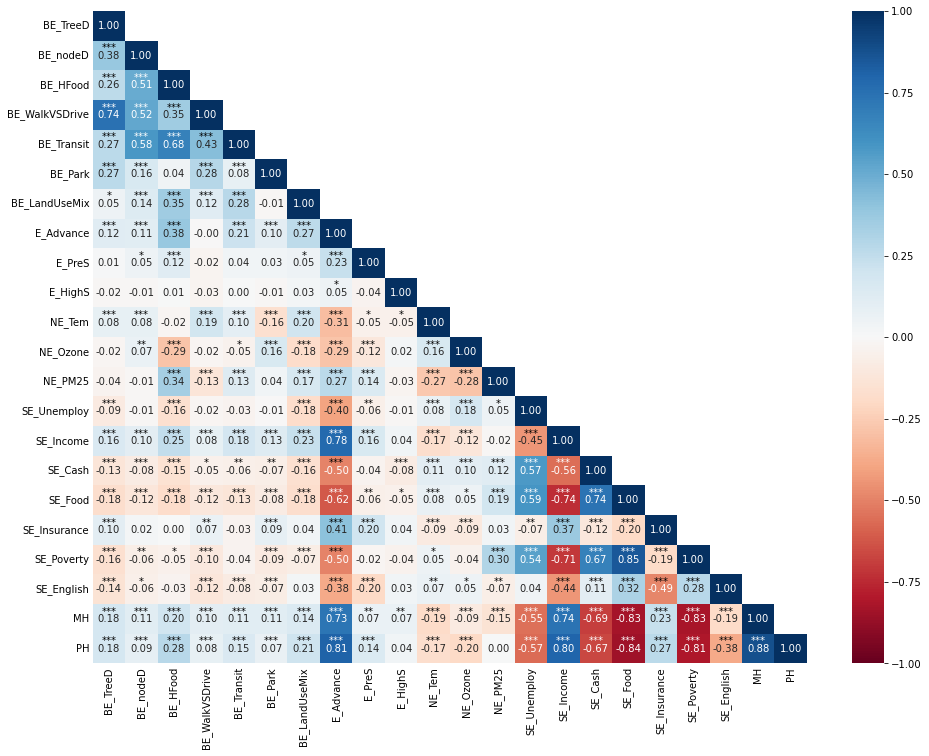

In [108]:
df_coor=data_Z.corr() 
fig = plt.figure(figsize=(16,12))
ax1 = plt.gca()


mask = np.zeros_like(df_coor)
mask[np.triu_indices_from(mask)] = True
mask2 = mask
mask = (np.flipud(mask)-1)*(-1)
mask = np.rot90(mask,k = -1)

im1 = sns.heatmap(df_coor,annot=True,cmap="RdBu"
, mask=mask # triangle format
,vmax=1,vmin=-1
, fmt='.2f',ax = ax1)

ax1.tick_params(axis = 'both', length=0)

# calculate P-value
df = data_Z
rlist = []
plist = []
for i in df.columns.values:
    for j in df.columns.values:
        r,p = pearsonr(df[i],df[j])
        rlist.append(r)
        plist.append(p)

rarr = np.asarray(rlist).reshape(len(df.columns.values),len(df.columns.values))
parr = np.asarray(plist).reshape(len(df.columns.values),len(df.columns.values))
xlist = ax1.get_xticks()
ylist = ax1.get_yticks()

widthx = 0
widthy = -0.15

for m in ax1.get_xticks():
    for n in ax1.get_yticks():
        pv = (parr[int(m),int(n)])
        rv = (rarr[int(m),int(n)])
        if mask2[int(m),int(n)]<1.:
            if abs(rv) > 0.5:
                if  pv< 0.05 and pv>= 0.01:
                    ax1.text(n+widthx,m+widthy,'*',ha = 'center',color = 'white')
                if  pv< 0.01 and pv>= 0.001:
                    ax1.text(n+widthx,m+widthy,'**',ha = 'center',color = 'white')
                if  pv< 0.001:
                    print([int(m),int(n)])
                    ax1.text(n+widthx,m+widthy,'***',ha = 'center',color = 'white')
            else: 
                if  pv< 0.05 and pv>= 0.01:
                    ax1.text(n+widthx,m+widthy,'*',ha = 'center',color = 'k')
                elif  pv< 0.01 and pv>= 0.001:
                    ax1.text(n+widthx,m+widthy,'**',ha = 'center',color = 'k')
                elif  pv< 0.001:
                    ax1.text(n+widthx,m+widthy,'***',ha = 'center',color = 'k')
#plt.savefig(r'Z:\GJ\pearsonr\fig\r_demo.png',dpi=600)
plt.show()

## Plot Data

In [12]:
# geo data
ct2010 = gpd.read_file('./Data/Processed_Data/ct2010_geoid.geojson')
ct2010.head()

dataGeo = pd.merge(data, ct2010[['GeoID','geometry']], left_index=True, right_on='GeoID').set_index('GeoID')
dataGeo =gpd.GeoDataFrame(dataGeo, geometry=dataGeo.geometry, crs=4326).to_crs(2263)
dataGeo.head()

BE_TreeD  BE_nodeD  BE_HFood  BE_WalkVSDrive  BE_Transit  \
GeoID                                                                   
36005000200  0.001039  0.000516  0.000000        0.000062    0.001033   
36005000400  0.000862  0.000332  0.000000        0.000054    0.000610   
36005001600  0.000784  0.000353  0.000177        0.000058    0.001719   
36005001900  0.000745  0.000271  0.000578        0.000171    0.010265   
36005002000  0.000580  0.000412  0.000121        0.000049    0.001279   

              BE_Park  BE_LandUseMix  BE_BikeD  E_Advance  E_PreS  E_HighS  \
GeoID                                                                        
36005000200  0.027208       0.160274  0.004839       29.4    29.9    100.0   
36005000400  0.014828       0.392961  0.024866       28.4    53.1    100.0   
36005001600  0.025224       0.442828  0.012343       18.5    76.6     90.6   
36005001900  0.078188       0.461624  0.030020       24.6    25.3     93.6   
36005002000  0.023708       0.274914  0.003655        8.4    87.5    100.0   

                NE_Tem   NE_Ozone   NE_PM25  SE_Unemploy  SE_Income  SE_Cash  \
GeoID                                                                          
36005000200  94.643103  42.521795  8.939136         13.5    51100.0      8.3   
36005000400  92.135510  42.587127  8.902753          6.2    78409.0      7.1   
36005001600  96.693606  42.587327  8.949253          4.8    34093.0      7.7   
36005001900  96.796323  42.051273  9.157725         10.7    45156.0      7.7   
36005002000  93.799532  42.509834  8.983487         18.9    20592.0     11.7   

             SE_Food  SE_Insurance  SE_Poverty  SE_English    MH    PH  \
GeoID                                                                    
36005000200     21.5          93.3        23.0        15.4  86.1  86.6   
36005000400      8.4          94.9         7.7        10.8  87.6  89.2   
36005001600     35.3          93.6        25.3        17.3  84.0  83.2   
36005001900     31.6          85.2        30.4        11.1  83.4  86.1   
36005002000     52.6          91.0        42.4        13.3  79.5  78.6   

                                                      geometry  
GeoID                                                           
36005000200  POLYGON ((1023972.528 232680.658, 1023970.431 ...  
36005000400  POLYGON ((1026849.274 235548.774, 1026749.976 ...  
36005001600  POLYGON ((1024344.112 238946.021, 1024391.333 ...  
36005001900  MULTIPOLYGON (((1012821.806 229228.265, 101278...  
36005002000  POLYGON ((1022317.859 237780.872, 1022425.769 ...

/Users/taoliang/opt/anaconda3/envs/MLC/lib/python3.7/site-packages/mapclassify/classifiers.py:239: UserWarning: Warning: Not enough unique values in array to form k classes
  "Warning: Not enough unique values in array to form k classes", UserWarning
/Users/taoliang/opt/anaconda3/envs/MLC/lib/python3.7/site-packages/mapclassify/classifiers.py:241: UserWarning: Warning: setting k to 4
  Warn("Warning: setting k to %d" % k_q, UserWarning)
/Users/taoliang/opt/anaconda3/envs/MLC/lib/python3.7/site-packages/mapclassify/classifiers.py:239: UserWarning: Warning: Not enough unique values in array to form k classes
  "Warning: Not enough unique values in array to form k classes", UserWarning
/Users/taoliang/opt/anaconda3/envs/MLC/lib/python3.7/site-packages/mapclassify/classifiers.py:241: UserWarning: Warning: setting k to 2
  Warn("Warning: setting k to %d" % k_q, UserWarning)


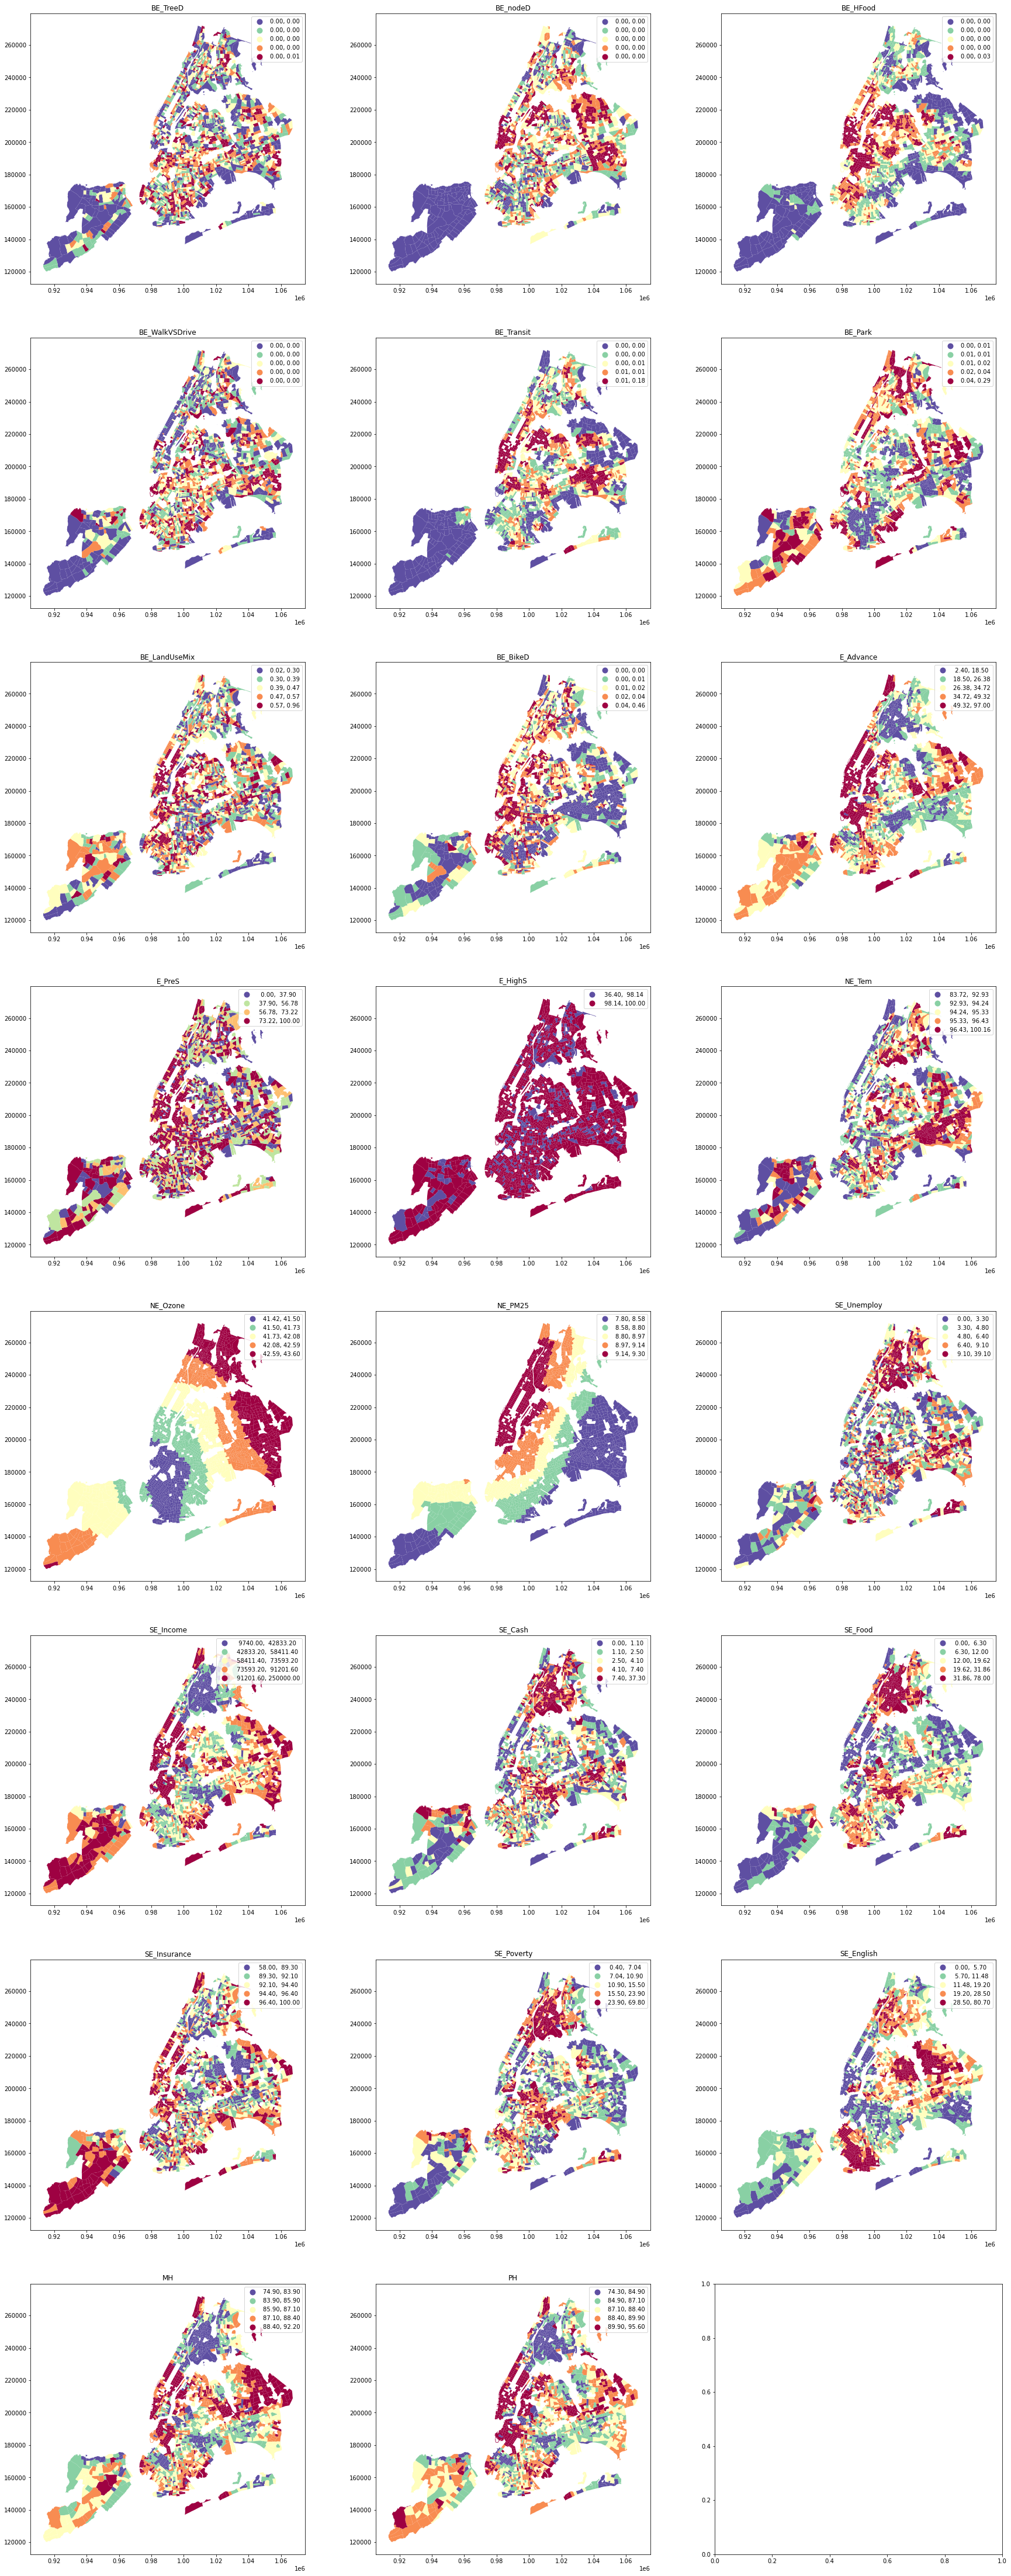

In [13]:
fig, ax = plt.subplots(8,3, figsize=(30,80))

a = dataGeo.columns[:-1]

for i,j in enumerate(a):
    dataGeo.plot(column=j, cmap='Spectral_r', ax=ax[i//3][i%3],
                              legend=True, scheme='Quantiles', k=5,
                              figsize=(5,5))
    label = j
    ax[i//3][i%3].set_title(label)
    
plt.show()

# 2. RandomForest Model Analysis

In [235]:
from sklearn.model_selection import cross_val_score
from sklearn.ensemble import RandomForestRegressor

In [226]:
data.head()

BE_TreeD  BE_nodeD  BE_HFood  BE_WalkVSDrive  BE_Transit  \
36005000200  0.001039  0.000516  0.000000        0.000062    0.001033   
36005000400  0.000862  0.000332  0.000000        0.000054    0.000610   
36005001600  0.000784  0.000353  0.000177        0.000058    0.001719   
36005001900  0.000745  0.000271  0.000578        0.000171    0.010265   
36005002000  0.000580  0.000412  0.000121        0.000049    0.001279   

              BE_Park  BE_LandUseMix  E_Advance  E_PreS  E_HighS     NE_Tem  \
36005000200  0.027208       0.160274       29.4    29.9    100.0  94.643103   
36005000400  0.014828       0.392961       28.4    53.1    100.0  92.135510   
36005001600  0.025224       0.442828       18.5    76.6     90.6  96.693606   
36005001900  0.078188       0.461624       24.6    25.3     93.6  96.796323   
36005002000  0.023708       0.274914        8.4    87.5    100.0  93.799532   

              NE_Ozone   NE_PM25  SE_Unemploy  SE_Income  SE_Cash  SE_Food  \
36005000200  42.521795  8.939136         13.5    51100.0      8.3     21.5   
36005000400  42.587127  8.902753          6.2    78409.0      7.1      8.4   
36005001600  42.587327  8.949253          4.8    34093.0      7.7     35.3   
36005001900  42.051273  9.157725         10.7    45156.0      7.7     31.6   
36005002000  42.509834  8.983487         18.9    20592.0     11.7     52.6   

             SE_Insurance  SE_Poverty  SE_English  MHLTH  PHLTH  
36005000200          93.3        23.0        15.4   13.9   13.4  
36005000400          94.9         7.7        10.8   12.4   10.8  
36005001600          93.6        25.3        17.3   16.0   16.8  
36005001900          85.2        30.4        11.1   16.6   13.9  
36005002000          91.0        42.4        13.3   20.5   21.4

In [251]:
X_all = data.iloc[:,:-2]
X_BE = data.iloc[:,:7]

In [233]:
y_MHLTH = data.MHLTH
y_PHLTH = data.PHLTH

## PHLTH: All indicators

310 0.8564975940286313 0.0034222128343180634
310 0.8564975940286313 0.0034222128343180634
310 0.8564975940286313 0.0034222128343180634 0.024015153353889564


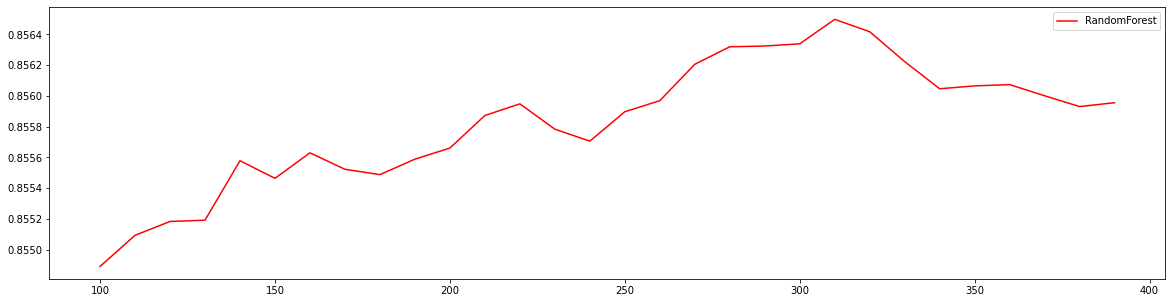

In [240]:
# Tunning n_estimators
axisx = np.arange(100,400,10)
rs = []
var = []
ge = []
for i in axisx:
    rfs = RandomForestRegressor(n_estimators=i
                                ,random_state=90)
    
    cvresult = cross_val_score(rfs,X_all,y_PHLTH,cv=10)
    rs.append(cvresult.mean())
    var.append(cvresult.var())
    ge.append((1 - cvresult.mean())**2+cvresult.var())
    
print(axisx[rs.index(max(rs))],max(rs),var[rs.index(max(rs))])
print(axisx[var.index(min(var))],rs[var.index(min(var))],min(var))
print(axisx[ge.index(min(ge))],rs[ge.index(min(ge))],var[ge.index(min(ge))],min(ge))
plt.figure(figsize=(20,5))
plt.plot(axisx,rs,c="red",label="RandomForest")
plt.legend()
plt.show()

16 0.8566838197276294 0.0033896197207774134
16 0.8566838197276294 0.0033896197207774134
16 0.8566838197276294 0.0033896197207774134 0.023929147248640037


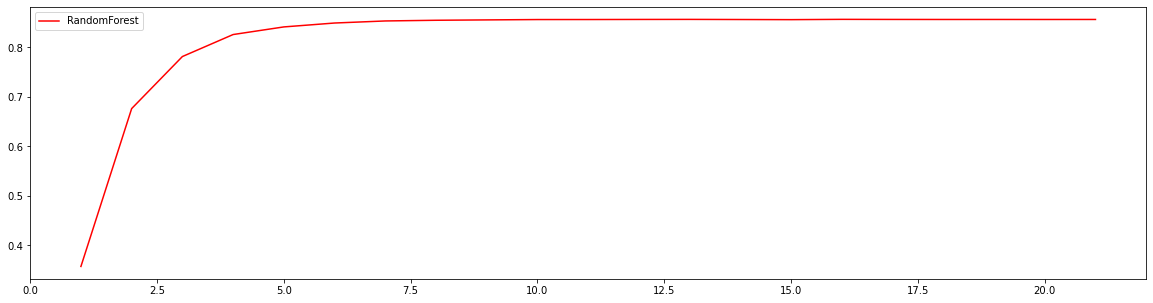

In [245]:
# Tunning max_depth
axisx = np.arange(1,22,1)
rs = []
var = []
ge = []
for i in axisx:
    rfs = RandomForestRegressor(n_estimators=310
                                ,max_depth=i
                                ,random_state=90)
    
    cvresult = cross_val_score(rfs,X_all,y_PHLTH,cv=10)
    rs.append(cvresult.mean())
    var.append(cvresult.var())
    ge.append((1 - cvresult.mean())**2+cvresult.var())
    
print(axisx[rs.index(max(rs))],max(rs),var[rs.index(max(rs))])
print(axisx[var.index(min(var))],rs[var.index(min(var))],min(var))
print(axisx[ge.index(min(ge))],rs[ge.index(min(ge))],var[ge.index(min(ge))],min(ge))
plt.figure(figsize=(20,5))
plt.plot(axisx,rs,c="red",label="RandomForest")
plt.legend()
plt.show()

In [246]:
# best model (our objective is not predict anything, just see the feature importance)
rfs = RandomForestRegressor(n_estimators=310,
                                max_depth=16,
                                n_jobs=-1,
                                random_state=90).fit(X_all,y_PHLTH)

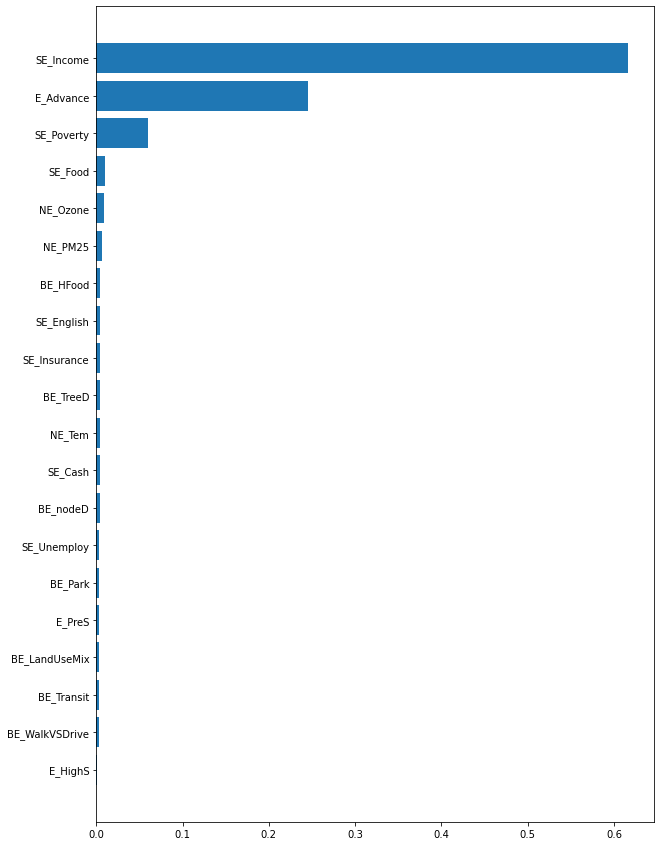

In [247]:
feature_imp = pd.DataFrame({'name':X_all.columns, 'value':rfs.feature_importances_}).sort_values(by='value',ascending=True)
plot, ax = plt.subplots(1,1,figsize = (10,15))
plt.barh(feature_imp.name, feature_imp.value)
plt.show()

## MHLTH: All indicators

300 0.7713396151777783 0.009546137459403933
160 0.7692161150425314 0.009405565240129764
300 0.7713396151777783 0.009546137459403933 0.06183170904645047


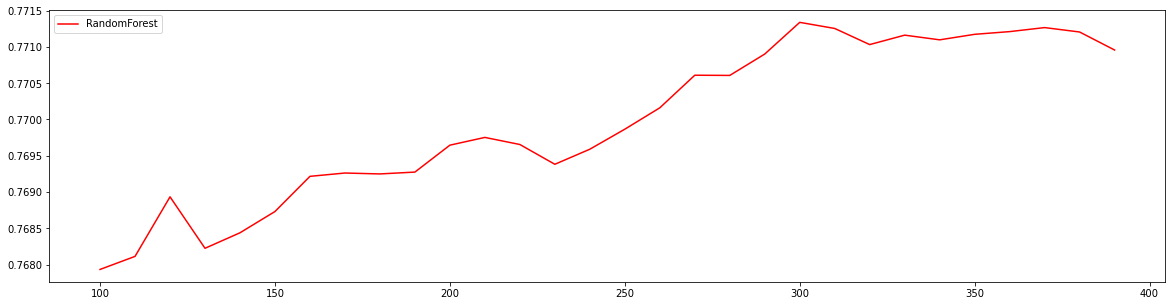

In [258]:
# Tunning n_estimators
axisx = np.arange(100,400,10)
rs = []
var = []
ge = []
for i in axisx:
    rfs = RandomForestRegressor(n_estimators=i
                                ,random_state=90)
    
    cvresult = cross_val_score(rfs,X_all,y_MHLTH,cv=10)
    rs.append(cvresult.mean())
    var.append(cvresult.var())
    ge.append((1 - cvresult.mean())**2+cvresult.var())
    
print(axisx[rs.index(max(rs))],max(rs),var[rs.index(max(rs))])
print(axisx[var.index(min(var))],rs[var.index(min(var))],min(var))
print(axisx[ge.index(min(ge))],rs[ge.index(min(ge))],var[ge.index(min(ge))],min(ge))
plt.figure(figsize=(20,5))
plt.plot(axisx,rs,c="red",label="RandomForest")
plt.legend()
plt.show()

16 0.7721653654695817 0.009375526224679197
16 0.7721653654695817 0.009375526224679197
16 0.7721653654695817 0.009375526224679197 0.06128414691628847


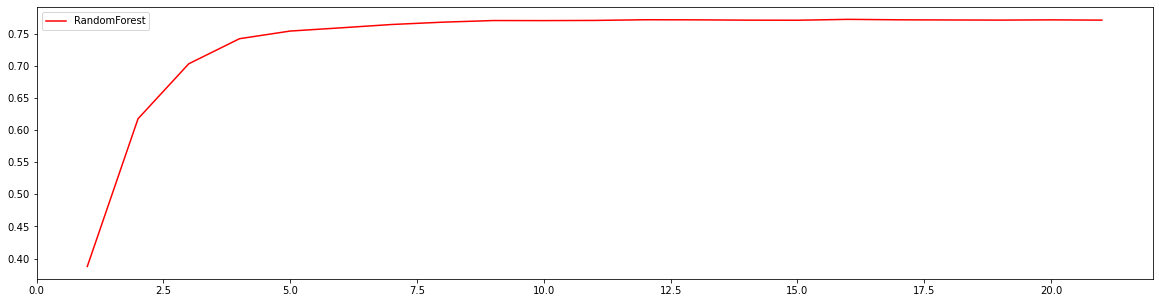

In [259]:
# Tunning max_depth
axisx = np.arange(1,22,1)
rs = []
var = []
ge = []
for i in axisx:
    rfs = RandomForestRegressor(n_estimators=300
                                ,max_depth=i
                                ,random_state=90)
    
    cvresult = cross_val_score(rfs,X_all,y_MHLTH,cv=10)
    rs.append(cvresult.mean())
    var.append(cvresult.var())
    ge.append((1 - cvresult.mean())**2+cvresult.var())
    
print(axisx[rs.index(max(rs))],max(rs),var[rs.index(max(rs))])
print(axisx[var.index(min(var))],rs[var.index(min(var))],min(var))
print(axisx[ge.index(min(ge))],rs[ge.index(min(ge))],var[ge.index(min(ge))],min(ge))
plt.figure(figsize=(20,5))
plt.plot(axisx,rs,c="red",label="RandomForest")
plt.legend()
plt.show()

In [260]:
# our objective is not predict anything, just see the feature importance
rfs = RandomForestRegressor(n_estimators=300
                            ,max_depth=16
                           ,random_state=90).fit(X_all,y_MHLTH)

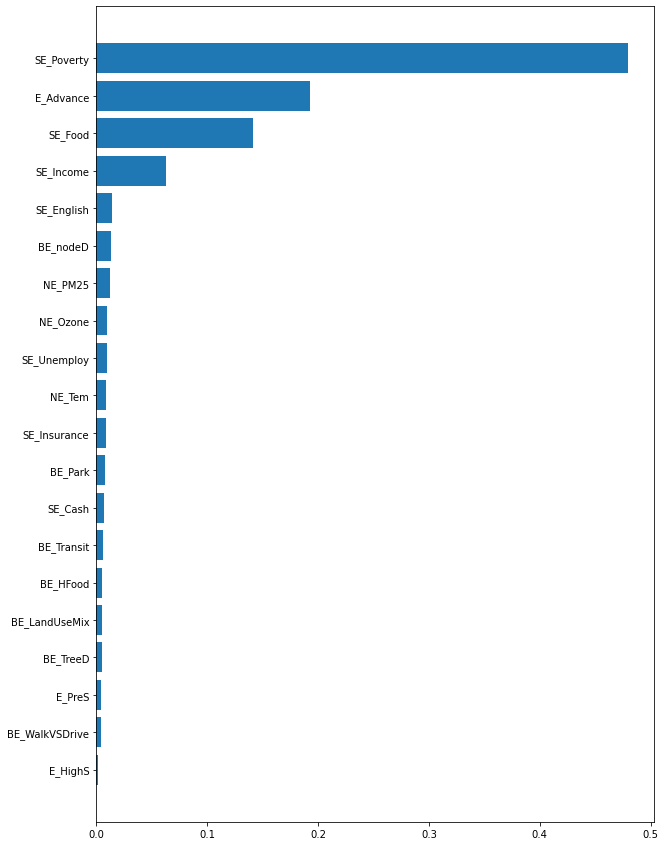

In [261]:
feature_imp = pd.DataFrame({'name':X_all.columns, 'value':rfs.feature_importances_}).sort_values(by='value',ascending=True)
plot, ax = plt.subplots(1,1,figsize = (10,15))
plt.barh(feature_imp.name, feature_imp.value)
plt.show()

## PHLTH: Built-Environment

In [252]:
rfs = RandomForestRegressor().fit(X_BE,y_PHLTH)

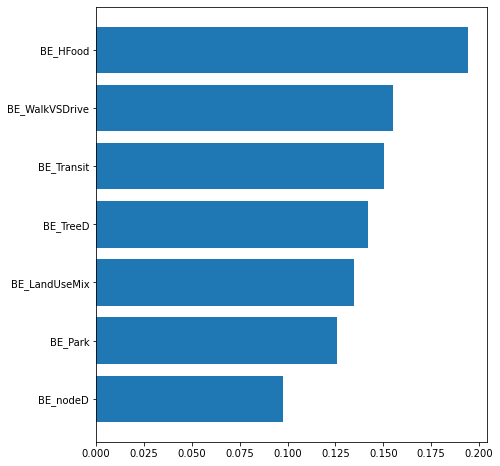

In [254]:
feature_imp = pd.DataFrame({'name':X_BE.columns, 'value':rfs.feature_importances_}).sort_values(by='value',ascending=True)
plot, ax = plt.subplots(1,1,figsize = (7,8))
plt.barh(feature_imp.name, feature_imp.value)
plt.show()

## MHLTH: Built-Environment

In [256]:
rfs = RandomForestRegressor().fit(X_BE,y_MHLTH)

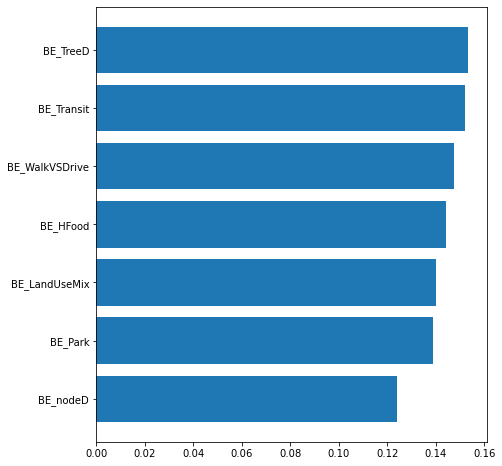

In [257]:
feature_imp = pd.DataFrame({'name':X_BE.columns, 'value':rfs.feature_importances_}).sort_values(by='value',ascending=True)
plot, ax = plt.subplots(1,1,figsize = (7,8))
plt.barh(feature_imp.name, feature_imp.value)
plt.show()

# 3. Calculate Score

## Indicators Weight

In [66]:
# filter out E_HighS, not significant. and SE_Cash SE_Food because they are highly correlate with income and poverty

In [114]:
df_Z = data_Z.drop(columns=['E_HighS'])
df_Z.head()

BE_TreeD  BE_nodeD  BE_HFood  BE_WalkVSDrive  BE_Transit   BE_Park  \
0 -0.662373  0.328594 -0.842791       -0.903941   -0.740547 -0.045052   
1 -0.818237 -0.117585 -0.842791       -1.036105   -0.781240 -0.391468   
2 -0.887313 -0.065845 -0.765981       -0.970307   -0.674569 -0.100558   
3 -0.921100 -0.266647 -0.592375        0.906876    0.147751  1.381428   
4 -1.066606  0.076357 -0.790389       -1.127281   -0.716906 -0.142972   

   BE_LandUseMix  E_Advance    E_PreS    NE_Tem  NE_Ozone   NE_PM25  \
0      -1.730821  -0.283513 -1.147894  0.015916  0.901082  0.307798   
1      -0.290617  -0.332932 -0.342632 -1.127930  1.022041  0.191383   
2       0.018036  -0.822187  0.473043  0.951260  1.022411  0.340169   
3       0.134369  -0.520727 -1.307558  0.998114  0.029927  1.007231   
4      -1.021263  -1.321325  0.851378 -0.368881  0.878936  0.449710   

   SE_Unemploy  SE_Income   SE_Cash   SE_Food  SE_Insurance  SE_Poverty  \
0     1.637542  -0.558324  0.870394  0.124573      0.176725    0.684679   
1    -0.070595   0.237456  0.594917 -0.721889      0.497105   -0.775590   
2    -0.398182  -1.053906  0.732656  1.016265      0.236796    0.904196   
3     0.982366  -0.731532  0.732656  0.777188     -1.445200    1.390952   
4     2.901095  -1.447323  1.650911  2.134112     -0.283822    2.536261   

   SE_English        MH        PH  
0   -0.197051  0.002955 -0.226785  
1   -0.531820  0.528212  0.532441  
2   -0.058777 -0.732407 -1.219620  
3   -0.509987 -0.942510 -0.372790  
4   -0.349880 -2.308180 -2.562867

In [115]:
# reversed features have negative correlation with health 
reverse = ['NE_Tem', 'NE_Ozone', 'NE_PM25', 'SE_Unemploy', 'SE_Poverty', 'SE_English','SE_Food','SE_Cash']
df_Z[reverse] = df_Z[reverse]*-1
df_Z.head()

BE_TreeD  BE_nodeD  BE_HFood  BE_WalkVSDrive  BE_Transit   BE_Park  \
0 -0.662373  0.328594 -0.842791       -0.903941   -0.740547 -0.045052   
1 -0.818237 -0.117585 -0.842791       -1.036105   -0.781240 -0.391468   
2 -0.887313 -0.065845 -0.765981       -0.970307   -0.674569 -0.100558   
3 -0.921100 -0.266647 -0.592375        0.906876    0.147751  1.381428   
4 -1.066606  0.076357 -0.790389       -1.127281   -0.716906 -0.142972   

   BE_LandUseMix  E_Advance    E_PreS    NE_Tem  NE_Ozone   NE_PM25  \
0      -1.730821  -0.283513 -1.147894 -0.015916 -0.901082 -0.307798   
1      -0.290617  -0.332932 -0.342632  1.127930 -1.022041 -0.191383   
2       0.018036  -0.822187  0.473043 -0.951260 -1.022411 -0.340169   
3       0.134369  -0.520727 -1.307558 -0.998114 -0.029927 -1.007231   
4      -1.021263  -1.321325  0.851378  0.368881 -0.878936 -0.449710   

   SE_Unemploy  SE_Income   SE_Cash   SE_Food  SE_Insurance  SE_Poverty  \
0    -1.637542  -0.558324 -0.870394 -0.124573      0.176725   -0.684679   
1     0.070595   0.237456 -0.594917  0.721889      0.497105    0.775590   
2     0.398182  -1.053906 -0.732656 -1.016265      0.236796   -0.904196   
3    -0.982366  -0.731532 -0.732656 -0.777188     -1.445200   -1.390952   
4    -2.901095  -1.447323 -1.650911 -2.134112     -0.283822   -2.536261   

   SE_English        MH        PH  
0    0.197051  0.002955 -0.226785  
1    0.531820  0.528212  0.532441  
2    0.058777 -0.732407 -1.219620  
3    0.509987 -0.942510 -0.372790  
4    0.349880 -2.308180 -2.562867

In [116]:
data_weight = df_Z.corr().iloc[:-2,-2:]
data_weight = data_weight.round(decimals=2)
data_weight

MH    PH
BE_TreeD        0.18  0.18
BE_nodeD        0.11  0.09
BE_HFood        0.20  0.28
BE_WalkVSDrive  0.10  0.08
BE_Transit      0.11  0.15
BE_Park         0.11  0.07
BE_LandUseMix   0.14  0.21
E_Advance       0.73  0.81
E_PreS          0.07  0.14
NE_Tem          0.19  0.17
NE_Ozone        0.09  0.20
NE_PM25         0.15 -0.00
SE_Unemploy     0.55  0.57
SE_Income       0.74  0.80
SE_Cash         0.69  0.67
SE_Food         0.83  0.84
SE_Insurance    0.23  0.27
SE_Poverty      0.83  0.81
SE_English      0.19  0.38

In [117]:
data_weight['Average_Coef'] = (data_weight['MH'] + data_weight['PH'])/2
data_weight

MH    PH  Average_Coef
BE_TreeD        0.18  0.18         0.180
BE_nodeD        0.11  0.09         0.100
BE_HFood        0.20  0.28         0.240
BE_WalkVSDrive  0.10  0.08         0.090
BE_Transit      0.11  0.15         0.130
BE_Park         0.11  0.07         0.090
BE_LandUseMix   0.14  0.21         0.175
E_Advance       0.73  0.81         0.770
E_PreS          0.07  0.14         0.105
NE_Tem          0.19  0.17         0.180
NE_Ozone        0.09  0.20         0.145
NE_PM25         0.15 -0.00         0.075
SE_Unemploy     0.55  0.57         0.560
SE_Income       0.74  0.80         0.770
SE_Cash         0.69  0.67         0.680
SE_Food         0.83  0.84         0.835
SE_Insurance    0.23  0.27         0.250
SE_Poverty      0.83  0.81         0.820
SE_English      0.19  0.38         0.285

## Domain Score

In [120]:
# domain weight
data_weight['Final_Weight'] = 0
data_weight['Final_Weight'][0:7] = data_weight.iloc[0:7,2]/data_weight.iloc[0:7,2].sum()
data_weight['Final_Weight'][7:9] = data_weight.iloc[7:9,2]/data_weight.iloc[7:9,2].sum()
data_weight['Final_Weight'][9:12] = abs(data_weight.iloc[9:12,2])/abs(data_weight.iloc[9:12,2]).sum()
data_weight['Final_Weight'][12:] = abs(data_weight.iloc[12:,2])/abs(data_weight.iloc[12:,2]).sum()
data_weight['Final_Weight'] = data_weight.Final_Weight.round(decimals=2)
data_weight

/Users/taoliang/opt/anaconda3/envs/MLC/lib/python3.7/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


MH    PH  Average_Coef  Final_Weight
BE_TreeD        0.18  0.18         0.180          0.18
BE_nodeD        0.11  0.09         0.100          0.10
BE_HFood        0.20  0.28         0.240          0.24
BE_WalkVSDrive  0.10  0.08         0.090          0.09
BE_Transit      0.11  0.15         0.130          0.13
BE_Park         0.11  0.07         0.090          0.09
BE_LandUseMix   0.14  0.21         0.175          0.17
E_Advance       0.73  0.81         0.770          0.88
E_PreS          0.07  0.14         0.105          0.12
NE_Tem          0.19  0.17         0.180          0.45
NE_Ozone        0.09  0.20         0.145          0.36
NE_PM25         0.15 -0.00         0.075          0.19
SE_Unemploy     0.55  0.57         0.560          0.13
SE_Income       0.74  0.80         0.770          0.18
SE_Cash         0.69  0.67         0.680          0.16
SE_Food         0.83  0.84         0.835          0.20
SE_Insurance    0.23  0.27         0.250          0.06
SE_Poverty      0.83  0.81         0.820          0.20
SE_English      0.19  0.38         0.285          0.07

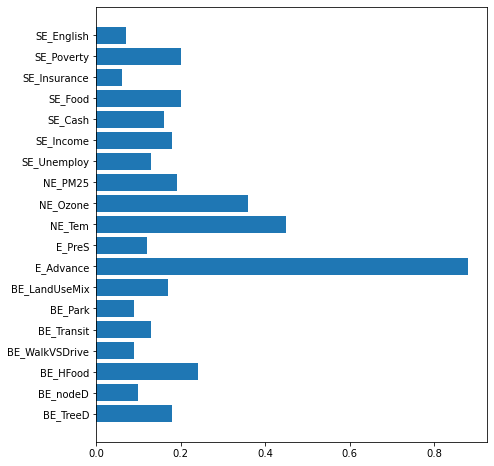

In [121]:
plot, ax = plt.subplots(1,1,figsize = (7,8))
plt.barh(data_weight.index, data_weight.Final_Weight)
plt.show()

In [122]:
df_Score = pd.DataFrame()
for i in df_Z.columns[:-2]:
    df_Score[i] = df_Z[i]*data_weight.loc[i,'Final_Weight']
df_Score

BE_TreeD  BE_nodeD  BE_HFood  BE_WalkVSDrive  BE_Transit   BE_Park  \
0    -0.119227  0.032859 -0.202270       -0.081355   -0.096271 -0.004055   
1    -0.147283 -0.011759 -0.202270       -0.093249   -0.101561 -0.035232   
2    -0.159716 -0.006584 -0.183835       -0.087328   -0.087694 -0.009050   
3    -0.165798 -0.026665 -0.142170        0.081619    0.019208  0.124329   
4    -0.191989  0.007636 -0.189693       -0.101455   -0.093198 -0.012868   
...        ...       ...       ...             ...         ...       ...   
1998 -0.197719 -0.092479 -0.168279       -0.111228   -0.109197 -0.063277   
1999 -0.070803 -0.092479 -0.138548        0.001436   -0.109197 -0.025382   
2000 -0.188939 -0.092479 -0.186943       -0.081090   -0.109197 -0.020653   
2001 -0.253627 -0.092479 -0.130938        0.083542   -0.109197  0.077395   
2002 -0.283818 -0.032543 -0.125881       -0.134362   -0.039920 -0.003159   

      BE_LandUseMix  E_Advance    E_PreS    NE_Tem  NE_Ozone   NE_PM25  \
0         -0.294239  -0.249491 -0.137747 -0.007162 -0.324390 -0.058482   
1         -0.049405  -0.292981 -0.041116  0.507569 -0.367935 -0.036363   
2          0.003066  -0.723524  0.056765 -0.428067 -0.368068 -0.064632   
3          0.022843  -0.458240 -0.156907 -0.449151 -0.010774 -0.191374   
4         -0.173615  -1.162766  0.102165  0.165997 -0.316417 -0.085445   
...             ...        ...       ...       ...       ...       ...   
1998      -0.058450  -0.219049  0.086338 -0.409477  0.053555 -0.018617   
1999      -0.092008  -0.801805 -0.262285 -0.343950  0.058214 -0.035440   
2000      -0.117921  -0.345168 -0.127334 -0.352865  0.065709 -0.048913   
2001      -0.007311  -0.680035  0.154230  0.592358  0.039465 -0.045132   
2002      -0.117095  -1.080137  0.060097  0.476332 -0.351397 -0.230593   

      SE_Unemploy  SE_Income   SE_Cash   SE_Food  SE_Insurance  SE_Poverty  \
0       -0.212880  -0.100498 -0.139263 -0.024915      0.010603   -0.136936   
1        0.009177   0.042742 -0.095187  0.144378      0.029826    0.155118   
2        0.051764  -0.189703 -0.117225 -0.203253      0.014208   -0.180839   
3       -0.127708  -0.131676 -0.117225 -0.155438     -0.086712   -0.278190   
4       -0.377142  -0.260518 -0.264146 -0.426822     -0.017029   -0.507252   
...           ...        ...       ...       ...           ...         ...   
1998     0.030471   0.080775  0.022350  0.083639      0.029826    0.015772   
1999     0.018303  -0.257067 -0.877540 -0.461715      0.045445   -0.362180   
2000     0.133895  -0.126630 -0.455143 -0.201961      0.029826   -0.234287   
2001     0.100434  -0.027124 -0.370663  0.026778      0.038236   -0.114030   
2002    -0.620493  -0.281546 -0.624102 -0.665899      0.013006   -0.734405   

      SE_English  
0       0.013794  
1       0.037227  
2       0.004114  
3       0.035699  
4       0.024492  
...          ...  
1998    0.050982  
1999    0.047416  
2000    0.057605  
2001    0.053020  
2002    0.034680  

[2003 rows x 19 columns]

In [123]:
df_Domain_Score = pd.DataFrame()
df_Domain_Score['BE'] = df_Score.iloc[:,0:7].sum(axis=1)
df_Domain_Score['E'] = df_Score.iloc[:,7:9].sum(axis=1)
df_Domain_Score['NE'] = df_Score.iloc[:,9:12].sum(axis=1)
df_Domain_Score['SE'] = df_Score.iloc[:,12:].sum(axis=1)
df_Domain_Score

BE         E        NE        SE
0    -0.764557 -0.387239 -0.390034 -0.590095
1    -0.640759 -0.334096  0.103271  0.323282
2    -0.531142 -0.666759 -0.860767 -0.620934
3    -0.086635 -0.615147 -0.651299 -0.861249
4    -0.755182 -1.060601 -0.235865 -1.828419
...        ...       ...       ...       ...
1998 -0.800629 -0.132711 -0.374538  0.313815
1999 -0.526981 -1.064090 -0.321176 -1.847338
2000 -0.797222 -0.472502 -0.336069 -0.796695
2001 -0.432614 -0.525805  0.586692 -0.293349
2002 -0.736778 -1.020039 -0.105658 -2.878759

[2003 rows x 4 columns]

In [124]:
df_Domain_Score.describe()

BE             E            NE            SE
count  2.003000e+03  2.003000e+03  2.003000e+03  2.003000e+03
mean   1.280941e-16  7.383011e-17 -1.810209e-15  3.336766e-16
std    6.509437e-01  9.149289e-01  5.792632e-01  7.856415e-01
min   -1.025116e+00 -1.582385e+00 -1.615106e+00 -3.311883e+00
25%   -4.181309e-01 -6.515689e-01 -4.200495e-01 -4.472246e-01
50%   -1.465253e-01 -2.213067e-01 -1.227284e-02  1.213934e-01
75%    2.541442e-01  4.197204e-01  4.008495e-01  5.520051e-01
max    6.071380e+00  2.844614e+00  2.598633e+00  1.935010e+00

In [125]:
# Z-score transform
Domain_scaler = StandardScaler().fit(df_Domain_Score)     
Domain_scale = Domain_scaler.transform(df_Domain_Score) 
df_Domain_Score_Z = pd.DataFrame(Domain_scale)
df_Domain_Score_Z.columns = df_Domain_Score.columns
df_Domain_Score_Z.head()

BE         E        NE        SE
0 -1.174830 -0.423350 -0.673495 -0.751287
1 -0.984599 -0.365252  0.178325  0.411591
2 -0.816160 -0.728937 -1.486340 -0.790551
3 -0.133125 -0.672512 -1.124639 -1.096511
4 -1.160424 -1.159506 -0.407283 -2.327875

In [126]:
df_Domain_Score_Z.describe()

BE             E            NE            SE
count  2.003000e+03  2.003000e+03  2.003000e+03  2.003000e+03
mean   5.875369e-18  2.704887e-17 -8.648155e-17 -7.737750e-16
std    1.000250e+00  1.000250e+00  1.000250e+00  1.000250e+00
min   -1.575208e+00 -1.729949e+00 -2.788903e+00 -4.216567e+00
25%   -6.425062e-01 -7.123303e-01 -7.253256e-01 -5.693898e-01
50%   -2.251530e-01 -2.419444e-01 -2.119227e-02  1.545536e-01
75%    3.905217e-01  4.588610e-01  6.921717e-01  7.027924e-01
max    9.329372e+00  3.109886e+00  4.487221e+00  2.463583e+00

[3, 1]
[4, 1]
[4, 3]
[5, 1]
[5, 3]
[5, 4]


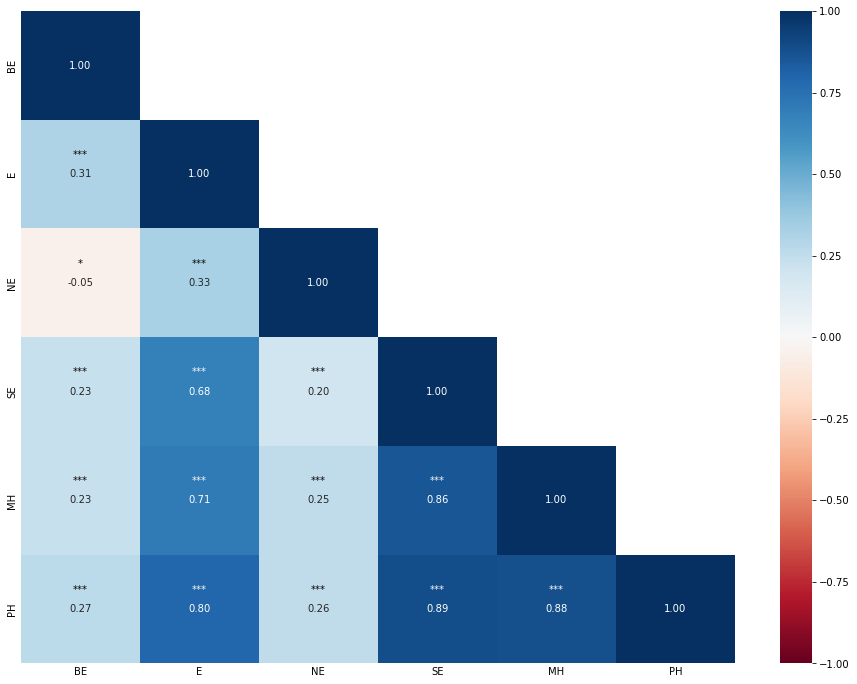

In [127]:
df_coor=pd.concat([df_Domain_Score_Z, df_Z[['MH','PH']]], axis=1).corr()
fig = plt.figure(figsize=(16,12))
ax1 = plt.gca()

#构造mask，去除重复数据显示
mask = np.zeros_like(df_coor)
mask[np.triu_indices_from(mask)] = True
mask2 = mask
mask = (np.flipud(mask)-1)*(-1)
mask = np.rot90(mask,k = -1)

im1 = sns.heatmap(df_coor,annot=True,cmap="RdBu"
, mask=mask#构造mask，去除重复数据显示
,vmax=1,vmin=-1
, fmt='.2f',ax = ax1)

ax1.tick_params(axis = 'both', length=0)

#计算相关性显著性并显示
df = pd.concat([df_Domain_Score_Z, df_Z[['MH','PH']]], axis=1)
rlist = []
plist = []
for i in df.columns.values:
    for j in df.columns.values:
        r,p = pearsonr(df[i],df[j])
        rlist.append(r)
        plist.append(p)

rarr = np.asarray(rlist).reshape(len(df.columns.values),len(df.columns.values))
parr = np.asarray(plist).reshape(len(df.columns.values),len(df.columns.values))
xlist = ax1.get_xticks()
ylist = ax1.get_yticks()

widthx = 0
widthy = -0.15

for m in ax1.get_xticks():
    for n in ax1.get_yticks():
        pv = (parr[int(m),int(n)])
        rv = (rarr[int(m),int(n)])
        if mask2[int(m),int(n)]<1.:
            if abs(rv) > 0.5:
                if  pv< 0.05 and pv>= 0.01:
                    ax1.text(n+widthx,m+widthy,'*',ha = 'center',color = 'white')
                if  pv< 0.01 and pv>= 0.001:
                    ax1.text(n+widthx,m+widthy,'**',ha = 'center',color = 'white')
                if  pv< 0.001:
                    print([int(m),int(n)])
                    ax1.text(n+widthx,m+widthy,'***',ha = 'center',color = 'white')
            else: 
                if  pv< 0.05 and pv>= 0.01:
                    ax1.text(n+widthx,m+widthy,'*',ha = 'center',color = 'k')
                elif  pv< 0.01 and pv>= 0.001:
                    ax1.text(n+widthx,m+widthy,'**',ha = 'center',color = 'k')
                elif  pv< 0.001:
                    ax1.text(n+widthx,m+widthy,'***',ha = 'center',color = 'k')
#plt.savefig(r'Z:\GJ\pearsonr\fig\r_demo.png',dpi=600)
plt.show()

## Domain Weight

In [128]:
data_Domain_weight = pd.concat([df_Domain_Score_Z, df_Z[['MH','PH']]], axis=1).corr().iloc[:-2,-2:].round(decimals=2)
data_Domain_weight['Averge_Domain_Weight'] = (data_Domain_weight['MH']+data_Domain_weight['PH'])/2
data_Domain_weight

MH    PH  Averge_Domain_Weight
BE  0.23  0.27                 0.250
E   0.71  0.80                 0.755
NE  0.25  0.26                 0.255
SE  0.86  0.89                 0.875

In [129]:
data_Domain_weight['Final_Domain_Weight'] = (data_Domain_weight['Averge_Domain_Weight']/data_Domain_weight['Averge_Domain_Weight'].sum()).round(decimals=2)
data_Domain_weight

MH    PH  Averge_Domain_Weight  Final_Domain_Weight
BE  0.23  0.27                 0.250                 0.12
E   0.71  0.80                 0.755                 0.35
NE  0.25  0.26                 0.255                 0.12
SE  0.86  0.89                 0.875                 0.41

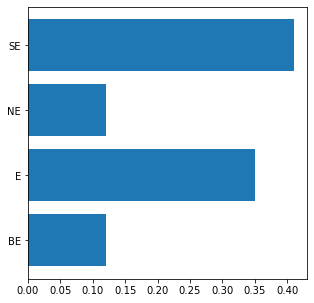

In [130]:
plot, ax = plt.subplots(1,1,figsize = (5,5))
plt.barh(data_Domain_weight.index, data_Domain_weight.Final_Domain_Weight)
plt.show()

## Healthy Corridor Index

In [131]:
df_Domain_Score_Z.head()

BE         E        NE        SE
0 -1.174830 -0.423350 -0.673495 -0.751287
1 -0.984599 -0.365252  0.178325  0.411591
2 -0.816160 -0.728937 -1.486340 -0.790551
3 -0.133125 -0.672512 -1.124639 -1.096511
4 -1.160424 -1.159506 -0.407283 -2.327875

In [132]:
df_HCI = pd.DataFrame()
for i in df_Domain_Score_Z.columns:
    df_HCI[i] = df_Domain_Score_Z[i]*data_Domain_weight.loc[i, 'Final_Domain_Weight']
df_HCI

BE         E        NE        SE
0    -0.140980 -0.148173 -0.080819 -0.308028
1    -0.118152 -0.127838  0.021399  0.168752
2    -0.097939 -0.255128 -0.178361 -0.324126
3    -0.015975 -0.235379 -0.134957 -0.449569
4    -0.139251 -0.405827 -0.048874 -0.954429
...        ...       ...       ...       ...
1998 -0.147631 -0.050780 -0.077609  0.163810
1999 -0.097172 -0.407162 -0.066551 -0.964304
2000 -0.147003 -0.180798 -0.069637 -0.415872
2001 -0.079771 -0.201194  0.121569 -0.153127
2002 -0.135857 -0.390307 -0.021893 -1.502703

[2003 rows x 4 columns]

In [133]:
df_HCI['HCI'] = df_HCI.sum(axis=1)
df_HCI

BE         E        NE        SE       HCI
0    -0.140980 -0.148173 -0.080819 -0.308028 -0.677999
1    -0.118152 -0.127838  0.021399  0.168752 -0.055839
2    -0.097939 -0.255128 -0.178361 -0.324126 -0.855554
3    -0.015975 -0.235379 -0.134957 -0.449569 -0.835880
4    -0.139251 -0.405827 -0.048874 -0.954429 -1.548381
...        ...       ...       ...       ...       ...
1998 -0.147631 -0.050780 -0.077609  0.163810 -0.112210
1999 -0.097172 -0.407162 -0.066551 -0.964304 -1.535190
2000 -0.147003 -0.180798 -0.069637 -0.415872 -0.813310
2001 -0.079771 -0.201194  0.121569 -0.153127 -0.312523
2002 -0.135857 -0.390307 -0.021893 -1.502703 -2.050760

[2003 rows x 5 columns]

In [134]:
df_HCI.describe()

BE             E            NE            SE           HCI
count  2.003000e+03  2.003000e+03  2.003000e+03  2.003000e+03  2.003000e+03
mean   3.838390e-18  5.049492e-17  1.013293e-17 -8.081404e-17  7.649065e-17
std    1.200300e-01  3.500874e-01  1.200300e-01  4.101024e-01  7.811230e-01
min   -1.890250e-01 -6.054820e-01 -3.346684e-01 -1.728792e+00 -2.218769e+00
25%   -7.710074e-02 -2.493156e-01 -8.703907e-02 -2.334498e-01 -4.739988e-01
50%   -2.701836e-02 -8.468055e-02 -2.543073e-03  6.336699e-02 -2.902199e-02
75%    4.686261e-02  1.606013e-01  8.306060e-02  2.881449e-01  4.259469e-01
max    1.119525e+00  1.088460e+00  5.384666e-01  1.010069e+00  2.290889e+00

In [135]:
# Z-score transform
HCI_scaler = StandardScaler().fit(df_HCI)     
HCI_scale = HCI_scaler.transform(df_HCI) 
df_HCI_Score_Z = pd.DataFrame(HCI_scale)
df_HCI_Score_Z.columns = df_HCI.columns
df_HCI_Score_Z = df_HCI_Score_Z[['HCI']]
df_HCI_Score_Z.head()

HCI
0 -0.868197
1 -0.071503
2 -1.095560
3 -1.070368
4 -1.982744

In [136]:
df_HCI_Score_Z.describe()

HCI
count  2.003000e+03
mean   6.097081e-17
std    1.000250e+00
min   -2.841195e+00
25%   -6.069686e-01
50%   -3.716347e-02
75%    5.454369e-01
max    2.933547e+00

## Combine all the Data

In [137]:
HCI = pd.concat([df_HCI_Score_Z, df_Domain_Score_Z, df_Z], axis=1).set_index(data.index)
HCI.head()

HCI        BE         E        NE        SE  BE_TreeD  \
36005000200 -0.868197 -1.174830 -0.423350 -0.673495 -0.751287 -0.662373   
36005000400 -0.071503 -0.984599 -0.365252  0.178325  0.411591 -0.818237   
36005001600 -1.095560 -0.816160 -0.728937 -1.486340 -0.790551 -0.887313   
36005001900 -1.070368 -0.133125 -0.672512 -1.124639 -1.096511 -0.921100   
36005002000 -1.982744 -1.160424 -1.159506 -0.407283 -2.327875 -1.066606   

             BE_nodeD  BE_HFood  BE_WalkVSDrive  BE_Transit   BE_Park  \
36005000200  0.328594 -0.842791       -0.903941   -0.740547 -0.045052   
36005000400 -0.117585 -0.842791       -1.036105   -0.781240 -0.391468   
36005001600 -0.065845 -0.765981       -0.970307   -0.674569 -0.100558   
36005001900 -0.266647 -0.592375        0.906876    0.147751  1.381428   
36005002000  0.076357 -0.790389       -1.127281   -0.716906 -0.142972   

             BE_LandUseMix  E_Advance    E_PreS    NE_Tem  NE_Ozone   NE_PM25  \
36005000200      -1.730821  -0.283513 -1.147894 -0.015916 -0.901082 -0.307798   
36005000400      -0.290617  -0.332932 -0.342632  1.127930 -1.022041 -0.191383   
36005001600       0.018036  -0.822187  0.473043 -0.951260 -1.022411 -0.340169   
36005001900       0.134369  -0.520727 -1.307558 -0.998114 -0.029927 -1.007231   
36005002000      -1.021263  -1.321325  0.851378  0.368881 -0.878936 -0.449710   

             SE_Unemploy  SE_Income   SE_Cash   SE_Food  SE_Insurance  \
36005000200    -1.637542  -0.558324 -0.870394 -0.124573      0.176725   
36005000400     0.070595   0.237456 -0.594917  0.721889      0.497105   
36005001600     0.398182  -1.053906 -0.732656 -1.016265      0.236796   
36005001900    -0.982366  -0.731532 -0.732656 -0.777188     -1.445200   
36005002000    -2.901095  -1.447323 -1.650911 -2.134112     -0.283822   

             SE_Poverty  SE_English        MH        PH  
36005000200   -0.684679    0.197051  0.002955 -0.226785  
36005000400    0.775590    0.531820  0.528212  0.532441  
36005001600   -0.904196    0.058777 -0.732407 -1.219620  
36005001900   -1.390952    0.509987 -0.942510 -0.372790  
36005002000   -2.536261    0.349880 -2.308180 -2.562867

In [138]:
HCI.describe()

HCI            BE             E            NE            SE  \
count  2.003000e+03  2.003000e+03  2.003000e+03  2.003000e+03  2.003000e+03   
mean   6.097081e-17  5.875369e-18  2.704887e-17 -8.648155e-17 -7.737750e-16   
std    1.000250e+00  1.000250e+00  1.000250e+00  1.000250e+00  1.000250e+00   
min   -2.841195e+00 -1.575208e+00 -1.729949e+00 -2.788903e+00 -4.216567e+00   
25%   -6.069686e-01 -6.425062e-01 -7.123303e-01 -7.253256e-01 -5.693898e-01   
50%   -3.716347e-02 -2.251530e-01 -2.419444e-01 -2.119227e-02  1.545536e-01   
75%    5.454369e-01  3.905217e-01  4.588610e-01  6.921717e-01  7.027924e-01   
max    2.933547e+00  9.329372e+00  3.109886e+00  4.487221e+00  2.463583e+00   

           BE_TreeD      BE_nodeD      BE_HFood  BE_WalkVSDrive    BE_Transit  \
count  2.003000e+03  2.003000e+03  2.003000e+03    2.003000e+03  2.003000e+03   
mean   8.580256e-17  1.830233e-16  1.001584e-16    5.875369e-17 -7.687865e-17   
std    1.000250e+00  1.000250e+00  1.000250e+00    1.000250e+00  1.000250e+00   
min   -1.576767e+00 -9.247896e-01 -8.427909e-01   -1.705593e+00 -8.399752e-01   
25%   -6.712587e-01 -6.056768e-01 -6.049943e-01   -7.271296e-01 -5.316181e-01   
50%   -2.240173e-01 -3.092471e-01 -3.002026e-01   -2.417505e-01 -2.624141e-01   
75%    4.123965e-01  2.228342e-01  2.565845e-01    4.773823e-01  1.744087e-01   
max    8.910007e+00  1.060682e+01  1.209812e+01    5.284428e+00  1.637621e+01   

            BE_Park  BE_LandUseMix     E_Advance        E_PreS        NE_Tem  \
count  2.003000e+03   2.003000e+03  2.003000e+03  2.003000e+03  2.003000e+03   
mean  -9.699902e-20  -9.744244e-17  1.050915e-16  3.436537e-18  2.993112e-18   
std    1.000250e+00   1.000250e+00  1.000250e+00  1.000250e+00  1.000250e+00   
min   -7.994300e-01  -2.607823e+00 -1.617843e+00 -2.185710e+00 -2.533679e+00   
25%   -6.318323e-01  -6.912042e-01 -7.233476e-01 -6.966696e-01 -7.168267e-01   
50%   -3.794621e-01  -4.852676e-02 -2.390351e-01  7.388305e-02 -1.046276e-01   
75%    2.189587e-01   6.529565e-01  4.651947e-01  8.392292e-01  6.119116e-01   
max    7.312495e+00   3.221531e+00  3.057255e+00  1.285247e+00  4.967190e+00   

           NE_Ozone       NE_PM25   SE_Unemploy     SE_Income       SE_Cash  \
count  2.003000e+03  2.003000e+03  2.003000e+03  2.003000e+03  2.003000e+03   
mean  -3.583310e-15 -2.897665e-15  2.239292e-16  3.225910e-17  9.522532e-16   
std    1.000250e+00  1.000250e+00  1.000250e+00  1.000250e+00  1.000250e+00   
min   -2.897435e+00 -1.455635e+00 -7.627718e+00 -1.763549e+00 -7.527743e+00   
25%   -8.367584e-01 -8.253654e-01 -3.973880e-01 -6.693617e-01 -4.342228e-01   
50%    2.937986e-01 -1.590663e-01  2.343885e-01 -1.329404e-01  3.003813e-01   
75%    9.171630e-01  6.647826e-01  6.789719e-01  4.601579e-01  7.135960e-01   
max    1.146729e+00  3.345059e+00  1.521340e+00  5.237595e+00  1.034985e+00   

            SE_Food  SE_Insurance    SE_Poverty    SE_English            MH  \
count  2.003000e+03  2.003000e+03  2.003000e+03  2.003000e+03  2.003000e+03   
mean  -2.979810e-16  2.169341e-15 -2.330194e-16  3.565407e-16 -1.543559e-15   
std    1.000250e+00  1.000250e+00  1.000250e+00  1.000250e+00  1.000250e+00   
min   -3.775344e+00 -6.891663e+00 -5.151382e+00 -4.555211e+00 -3.918971e+00   
25%   -5.316497e-01 -4.640354e-01 -5.319710e-01 -5.598180e-01 -5.573206e-01   
50%    2.889661e-01  1.767249e-01  2.602008e-01  1.897731e-01  1.430233e-01   
75%    7.865048e-01  7.173665e-01  7.469570e-01  8.156453e-01  6.682812e-01   
max    1.264659e+00  1.518317e+00  1.472319e+00  1.317799e+00  2.139003e+00   

                 PH  
count  2.003000e+03  
mean   2.153046e-15  
std    1.000250e+00  
min   -3.818510e+00  
25%   -5.187955e-01  
50%    9.442586e-02  
75%    5.908431e-01  
max    2.401306e+00

In [139]:
bins=[HCI['HCI'].quantile(0)-1
      , HCI['HCI'].quantile(0.2)
      , HCI['HCI'].quantile(0.4)
      , HCI['HCI'].quantile(0.6)
      , HCI['HCI'].quantile(0.8)
      ,HCI['HCI'].quantile(1)+1]

HCI['HCI_Class'] = pd.cut(HCI['HCI'], bins=bins, labels=['very_unhealthy','unhealthy','moderate','healthy','very healthy'])
HCI.head()

HCI        BE         E        NE        SE  BE_TreeD  \
36005000200 -0.868197 -1.174830 -0.423350 -0.673495 -0.751287 -0.662373   
36005000400 -0.071503 -0.984599 -0.365252  0.178325  0.411591 -0.818237   
36005001600 -1.095560 -0.816160 -0.728937 -1.486340 -0.790551 -0.887313   
36005001900 -1.070368 -0.133125 -0.672512 -1.124639 -1.096511 -0.921100   
36005002000 -1.982744 -1.160424 -1.159506 -0.407283 -2.327875 -1.066606   

             BE_nodeD  BE_HFood  BE_WalkVSDrive  BE_Transit   BE_Park  \
36005000200  0.328594 -0.842791       -0.903941   -0.740547 -0.045052   
36005000400 -0.117585 -0.842791       -1.036105   -0.781240 -0.391468   
36005001600 -0.065845 -0.765981       -0.970307   -0.674569 -0.100558   
36005001900 -0.266647 -0.592375        0.906876    0.147751  1.381428   
36005002000  0.076357 -0.790389       -1.127281   -0.716906 -0.142972   

             BE_LandUseMix  E_Advance    E_PreS    NE_Tem  NE_Ozone   NE_PM25  \
36005000200      -1.730821  -0.283513 -1.147894 -0.015916 -0.901082 -0.307798   
36005000400      -0.290617  -0.332932 -0.342632  1.127930 -1.022041 -0.191383   
36005001600       0.018036  -0.822187  0.473043 -0.951260 -1.022411 -0.340169   
36005001900       0.134369  -0.520727 -1.307558 -0.998114 -0.029927 -1.007231   
36005002000      -1.021263  -1.321325  0.851378  0.368881 -0.878936 -0.449710   

             SE_Unemploy  SE_Income   SE_Cash   SE_Food  SE_Insurance  \
36005000200    -1.637542  -0.558324 -0.870394 -0.124573      0.176725   
36005000400     0.070595   0.237456 -0.594917  0.721889      0.497105   
36005001600     0.398182  -1.053906 -0.732656 -1.016265      0.236796   
36005001900    -0.982366  -0.731532 -0.732656 -0.777188     -1.445200   
36005002000    -2.901095  -1.447323 -1.650911 -2.134112     -0.283822   

             SE_Poverty  SE_English        MH        PH       HCI_Class  
36005000200   -0.684679    0.197051  0.002955 -0.226785  very_unhealthy  
36005000400    0.775590    0.531820  0.528212  0.532441        moderate  
36005001600   -0.904196    0.058777 -0.732407 -1.219620  very_unhealthy  
36005001900   -1.390952    0.509987 -0.942510 -0.372790  very_unhealthy  
36005002000   -2.536261    0.349880 -2.308180 -2.562867  very_unhealthy

In [140]:
HCI.groupby('HCI_Class').count()

HCI   BE    E   NE   SE  BE_TreeD  BE_nodeD  BE_HFood  \
HCI_Class                                                               
very_unhealthy  401  401  401  401  401       401       401       401   
unhealthy       400  400  400  400  400       400       400       400   
moderate        401  401  401  401  401       401       401       401   
healthy         400  400  400  400  400       400       400       400   
very healthy    401  401  401  401  401       401       401       401   

                BE_WalkVSDrive  BE_Transit  BE_Park  BE_LandUseMix  E_Advance  \
HCI_Class                                                                       
very_unhealthy             401         401      401            401        401   
unhealthy                  400         400      400            400        400   
moderate                   401         401      401            401        401   
healthy                    400         400      400            400        400   
very healthy               401         401      401            401        401   

                E_PreS  NE_Tem  NE_Ozone  NE_PM25  SE_Unemploy  SE_Income  \
HCI_Class                                                                   
very_unhealthy     401     401       401      401          401        401   
unhealthy          400     400       400      400          400        400   
moderate           401     401       401      401          401        401   
healthy            400     400       400      400          400        400   
very healthy       401     401       401      401          401        401   

                SE_Cash  SE_Food  SE_Insurance  SE_Poverty  SE_English   MH  \
HCI_Class                                                                     
very_unhealthy      401      401           401         401         401  401   
unhealthy           400      400           400         400         400  400   
moderate            401      401           401         401         401  401   
healthy             400      400           400         400         400  400   
very healthy        401      401           401         401         401  401   

                 PH  
HCI_Class            
very_unhealthy  401  
unhealthy       400  
moderate        401  
healthy         400  
very healthy    401

# Validation

## OLS model

In [141]:
est = sm.OLS(HCI['MH'], HCI['HCI']).fit()
est.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 OLS Regression Results                                
=======================================================================================
Dep. Variable:                     MH   R-squared (uncentered):                   0.709
Model:                            OLS   Adj. R-squared (uncentered):              0.709
Method:                 Least Squares   F-statistic:                              4880.
Date:                Mon, 09 May 2022   Prob (F-statistic):                        0.00
Time:                        00:24:57   Log-Likelihood:                         -1605.6
No. Observations:                2003   AIC:                                      3213.
Df Residuals:                    2002   BIC:                                      3219.
Df Model:                           1                                                  
Covariance Type:            nonrobust                                                  
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
HCI            0.8421      0.012     69.855      0.000       0.818       0.866
==============================================================================
Omnibus:                      308.587   Durbin-Watson:                   1.261
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              760.951
Skew:                          -0.852   Prob(JB):                    5.78e-166
Kurtosis:                       5.492   Cond. No.                         1.00
==============================================================================

Notes:
[1] R² is computed without centering (uncentered) since the model does not contain a constant.
[2] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [142]:
est = sm.OLS(HCI['PH'], HCI['HCI']).fit()
est.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 OLS Regression Results                                
=======================================================================================
Dep. Variable:                     PH   R-squared (uncentered):                   0.818
Model:                            OLS   Adj. R-squared (uncentered):              0.818
Method:                 Least Squares   F-statistic:                              8993.
Date:                Mon, 09 May 2022   Prob (F-statistic):                        0.00
Time:                        00:25:01   Log-Likelihood:                         -1136.3
No. Observations:                2003   AIC:                                      2275.
Df Residuals:                    2002   BIC:                                      2280.
Df Model:                           1                                                  
Covariance Type:            nonrobust                                                  
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
HCI            0.9044      0.010     94.831      0.000       0.886       0.923
==============================================================================
Omnibus:                      345.017   Durbin-Watson:                   1.593
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              792.921
Skew:                          -0.969   Prob(JB):                    6.60e-173
Kurtosis:                       5.397   Cond. No.                         1.00
==============================================================================

Notes:
[1] R² is computed without centering (uncentered) since the model does not contain a constant.
[2] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [42]:
for i in ['BE','E','NE','SE']:
    est = sm.OLS(HCI['MH'], HCI[i]).fit()
    print(est.summary())
    print('***'*30)
    print('***'*30)

                                 OLS Regression Results                                
Dep. Variable:                     MH   R-squared (uncentered):                   0.049
Model:                            OLS   Adj. R-squared (uncentered):              0.049
Method:                 Least Squares   F-statistic:                              103.4
Date:                Mon, 09 May 2022   Prob (F-statistic):                    1.02e-23
Time:                        00:15:11   Log-Likelihood:                         -2791.7
No. Observations:                2003   AIC:                                      5585.
Df Residuals:                    2002   BIC:                                      5591.
Df Model:                           1                                                  
Covariance Type:            nonrobust                                                  
                 coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------

In [43]:
for i in ['BE','E','NE','SE']:
    est = sm.OLS(HCI['PH'], HCI[i]).fit()
    print(est.summary())
    print('***'*30)
    print('***'*30)

                                 OLS Regression Results                                
Dep. Variable:                     PH   R-squared (uncentered):                   0.071
Model:                            OLS   Adj. R-squared (uncentered):              0.071
Method:                 Least Squares   F-statistic:                              153.4
Date:                Mon, 09 May 2022   Prob (F-statistic):                    5.40e-34
Time:                        00:15:12   Log-Likelihood:                         -2768.2
No. Observations:                2003   AIC:                                      5538.
Df Residuals:                    2002   BIC:                                      5544.
Df Model:                           1                                                  
Covariance Type:            nonrobust                                                  
                 coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------

## Other Health Outcomes

In [143]:
Health_Outcomes = pd.read_csv('./Data/Processed_Data/Domain/Health_Outcomes.csv', index_col=0)
Health_Outcomes.head()

ARTHRITIS  BPHIGH  CANCER  CASTHMA  CHD  COPD  DEPRESSION  \
GeoID                                                                    
36005000100       11.4    28.6     2.1     11.1  3.8   5.5        15.1   
36005000200       18.0    30.3     4.9     10.4  5.2   5.2        15.2   
36005000400       15.6    26.8     4.5      9.8  3.9   3.9        14.5   
36005001600       22.2    35.8     5.7     11.8  7.0   7.3        16.4   
36005001900       15.2    28.1     3.5     10.8  4.7   5.4        16.6   

             DIABETES  HIGHCHOL  KIDNEY  OBESITY  STROKE  TEETHLOST  
GeoID                                                                
36005000100       9.4      22.1     2.3     34.5     2.7       29.4  
36005000200      13.6      30.1     3.3     31.8     3.1       15.5  
36005000400      11.0      28.0     2.7     30.2     2.4       10.6  
36005001600      16.8      32.2     4.3     35.0     4.3       19.3  
36005001900      11.6      26.1     2.9     33.9     2.8       18.6

In [144]:
HCI_Disease = HCI.merge(Health_Outcomes, left_index=True, right_index=True)
HCI_Disease.head()

HCI        BE         E        NE        SE  BE_TreeD  \
36005000200 -0.868197 -1.174830 -0.423350 -0.673495 -0.751287 -0.662373   
36005000400 -0.071503 -0.984599 -0.365252  0.178325  0.411591 -0.818237   
36005001600 -1.095560 -0.816160 -0.728937 -1.486340 -0.790551 -0.887313   
36005001900 -1.070368 -0.133125 -0.672512 -1.124639 -1.096511 -0.921100   
36005002000 -1.982744 -1.160424 -1.159506 -0.407283 -2.327875 -1.066606   

             BE_nodeD  BE_HFood  BE_WalkVSDrive  BE_Transit   BE_Park  \
36005000200  0.328594 -0.842791       -0.903941   -0.740547 -0.045052   
36005000400 -0.117585 -0.842791       -1.036105   -0.781240 -0.391468   
36005001600 -0.065845 -0.765981       -0.970307   -0.674569 -0.100558   
36005001900 -0.266647 -0.592375        0.906876    0.147751  1.381428   
36005002000  0.076357 -0.790389       -1.127281   -0.716906 -0.142972   

             BE_LandUseMix  E_Advance    E_PreS    NE_Tem  NE_Ozone   NE_PM25  \
36005000200      -1.730821  -0.283513 -1.147894 -0.015916 -0.901082 -0.307798   
36005000400      -0.290617  -0.332932 -0.342632  1.127930 -1.022041 -0.191383   
36005001600       0.018036  -0.822187  0.473043 -0.951260 -1.022411 -0.340169   
36005001900       0.134369  -0.520727 -1.307558 -0.998114 -0.029927 -1.007231   
36005002000      -1.021263  -1.321325  0.851378  0.368881 -0.878936 -0.449710   

             SE_Unemploy  SE_Income   SE_Cash   SE_Food  SE_Insurance  \
36005000200    -1.637542  -0.558324 -0.870394 -0.124573      0.176725   
36005000400     0.070595   0.237456 -0.594917  0.721889      0.497105   
36005001600     0.398182  -1.053906 -0.732656 -1.016265      0.236796   
36005001900    -0.982366  -0.731532 -0.732656 -0.777188     -1.445200   
36005002000    -2.901095  -1.447323 -1.650911 -2.134112     -0.283822   

             SE_Poverty  SE_English        MH        PH       HCI_Class  \
36005000200   -0.684679    0.197051  0.002955 -0.226785  very_unhealthy   
36005000400    0.775590    0.531820  0.528212  0.532441        moderate   
36005001600   -0.904196    0.058777 -0.732407 -1.219620  very_unhealthy   
36005001900   -1.390952    0.509987 -0.942510 -0.372790  very_unhealthy   
36005002000   -2.536261    0.349880 -2.308180 -2.562867  very_unhealthy   

             ARTHRITIS  BPHIGH  CANCER  CASTHMA  CHD  COPD  DEPRESSION  \
36005000200       18.0    30.3     4.9     10.4  5.2   5.2        15.2   
36005000400       15.6    26.8     4.5      9.8  3.9   3.9        14.5   
36005001600       22.2    35.8     5.7     11.8  7.0   7.3        16.4   
36005001900       15.2    28.1     3.5     10.8  4.7   5.4        16.6   
36005002000       23.3    38.0     4.9     13.7  7.8   9.8        18.6   

             DIABETES  HIGHCHOL  KIDNEY  OBESITY  STROKE  TEETHLOST  
36005000200      13.6      30.1     3.3     31.8     3.1       15.5  
36005000400      11.0      28.0     2.7     30.2     2.4       10.6  
36005001600      16.8      32.2     4.3     35.0     4.3       19.3  
36005001900      11.6      26.1     2.9     33.9     2.8       18.6  
36005002000      19.1      32.0     4.8     38.9     5.3       29.0

In [145]:
HCI_Disease

HCI        BE         E        NE        SE  BE_TreeD  \
36005000200 -0.868197 -1.174830 -0.423350 -0.673495 -0.751287 -0.662373   
36005000400 -0.071503 -0.984599 -0.365252  0.178325  0.411591 -0.818237   
36005001600 -1.095560 -0.816160 -0.728937 -1.486340 -0.790551 -0.887313   
36005001900 -1.070368 -0.133125 -0.672512 -1.124639 -1.096511 -0.921100   
36005002000 -1.982744 -1.160424 -1.159506 -0.407283 -2.327875 -1.066606   
...               ...       ...       ...       ...       ...       ...   
36085030302 -0.143688 -1.230259 -0.145087 -0.646738  0.399538 -1.098438   
36085031901 -1.965854 -0.809767 -1.163321 -0.554594 -2.351962 -0.393352   
36085031902 -1.041466 -1.225023 -0.516565 -0.580312 -1.014322 -1.049660   
36085032300 -0.400194 -0.664761 -0.574839  1.013077 -0.373481 -1.409038   
36005005300 -2.626056 -1.132144 -1.115162 -0.182446 -3.665129 -1.576767   

             BE_nodeD  BE_HFood  BE_WalkVSDrive  BE_Transit   BE_Park  \
36005000200  0.328594 -0.842791       -0.903941   -0.740547 -0.045052   
36005000400 -0.117585 -0.842791       -1.036105   -0.781240 -0.391468   
36005001600 -0.065845 -0.765981       -0.970307   -0.674569 -0.100558   
36005001900 -0.266647 -0.592375        0.906876    0.147751  1.381428   
36005002000  0.076357 -0.790389       -1.127281   -0.716906 -0.142972   
...               ...       ...             ...         ...       ...   
36085030302 -0.924790 -0.701163       -1.235869   -0.839975 -0.703081   
36085031901 -0.924790 -0.577283        0.015960   -0.839975 -0.282025   
36085031902 -0.924790 -0.778929       -0.901001   -0.839975 -0.229482   
36085032300 -0.924790 -0.545574        0.928247   -0.839975  0.859943   
36005005300 -0.325428 -0.524504       -1.492913   -0.307073 -0.035103   

             BE_LandUseMix  E_Advance    E_PreS    NE_Tem  NE_Ozone   NE_PM25  \
36005000200      -1.730821  -0.283513 -1.147894 -0.015916 -0.901082 -0.307798   
36005000400      -0.290617  -0.332932 -0.342632  1.127930 -1.022041 -0.191383   
36005001600       0.018036  -0.822187  0.473043 -0.951260 -1.022411 -0.340169   
36005001900       0.134369  -0.520727 -1.307558 -0.998114 -0.029927 -1.007231   
36005002000      -1.021263  -1.321325  0.851378  0.368881 -0.878936 -0.449710   
...                    ...        ...       ...       ...       ...       ...   
36085030302      -0.343824  -0.248919  0.719481 -0.909948  0.148765 -0.097984   
36085031901      -0.541223  -0.911142 -2.185710 -0.764333  0.161705 -0.186525   
36085031902      -0.693652  -0.392236 -1.061120 -0.784145  0.182526 -0.257438   
36085032300      -0.043004  -0.772767  1.285247  1.316352  0.109625 -0.237536   
36005005300      -0.688796  -1.227428  0.500811  1.058516 -0.976103 -1.213646   

             SE_Unemploy  SE_Income   SE_Cash   SE_Food  SE_Insurance  \
36005000200    -1.637542  -0.558324 -0.870394 -0.124573      0.176725   
36005000400     0.070595   0.237456 -0.594917  0.721889      0.497105   
36005001600     0.398182  -1.053906 -0.732656 -1.016265      0.236796   
36005001900    -0.982366  -0.731532 -0.732656 -0.777188     -1.445200   
36005002000    -2.901095  -1.447323 -1.650911 -2.134112     -0.283822   
...                  ...        ...       ...       ...           ...   
36085030302     0.234388   0.448750  0.139687  0.418197      0.497105   
36085031901     0.140792  -1.428149 -5.484626 -2.308574      0.757414   
36085031902     1.029959  -0.703499 -2.844642 -1.009804      0.497105   
36085032300     0.772568  -0.150687 -2.316646  0.133889      0.637271   
36005005300    -4.773025  -1.564145 -3.900636 -3.329497      0.216772   

             SE_Poverty  SE_English        MH        PH       HCI_Class  \
36005000200   -0.684679    0.197051  0.002955 -0.226785  very_unhealthy   
36005000400    0.775590    0.531820  0.528212  0.532441        moderate   
36005001600   -0.904196    0.058777 -0.732407 -1.219620  very_unhealthy   
36005001900   -1.390952    0.509987 -0.942510 -0.372790  very_unhealthy   
36005002000   -

In [146]:
est = sm.OLS(HCI_Disease['OBESITY'], sm.add_constant(HCI_Disease['HCI'])).fit()
est.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                OBESITY   R-squared:                       0.575
Model:                            OLS   Adj. R-squared:                  0.575
Method:                 Least Squares   F-statistic:                     2705.
Date:                Mon, 09 May 2022   Prob (F-statistic):               0.00
Time:                        00:25:14   Log-Likelihood:                -5638.8
No. Observations:                2003   AIC:                         1.128e+04
Df Residuals:                    2001   BIC:                         1.129e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         26.3777      0.090    292.062      0.000      26.201      26.555
HCI           -4.6969      0.090    -52.006      0.000      -4.874      -4.520
==============================================================================
Omnibus:                       57.418   Durbin-Watson:                   1.289
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               61.943
Skew:                          -0.429   Prob(JB):                     3.54e-14
Kurtosis:                       2.914   Cond. No.                         1.00
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [147]:
HCI_Disease.columns

Index(['HCI', 'BE', 'E', 'NE', 'SE', 'BE_TreeD', 'BE_nodeD', 'BE_HFood',
       'BE_WalkVSDrive', 'BE_Transit', 'BE_Park', 'BE_LandUseMix', 'E_Advance',
       'E_PreS', 'NE_Tem', 'NE_Ozone', 'NE_PM25', 'SE_Unemploy', 'SE_Income',
       'SE_Cash', 'SE_Food', 'SE_Insurance', 'SE_Poverty', 'SE_English', 'MH',
       'PH', 'HCI_Class', 'ARTHRITIS', 'BPHIGH', 'CANCER', 'CASTHMA', 'CHD',
       'COPD', 'DEPRESSION', 'DIABETES', 'HIGHCHOL', 'KIDNEY', 'OBESITY',
       'STROKE', 'TEETHLOST'],
      dtype='object')

In [148]:
HCI_Disease = HCI_Disease.groupby('HCI_Class').mean()

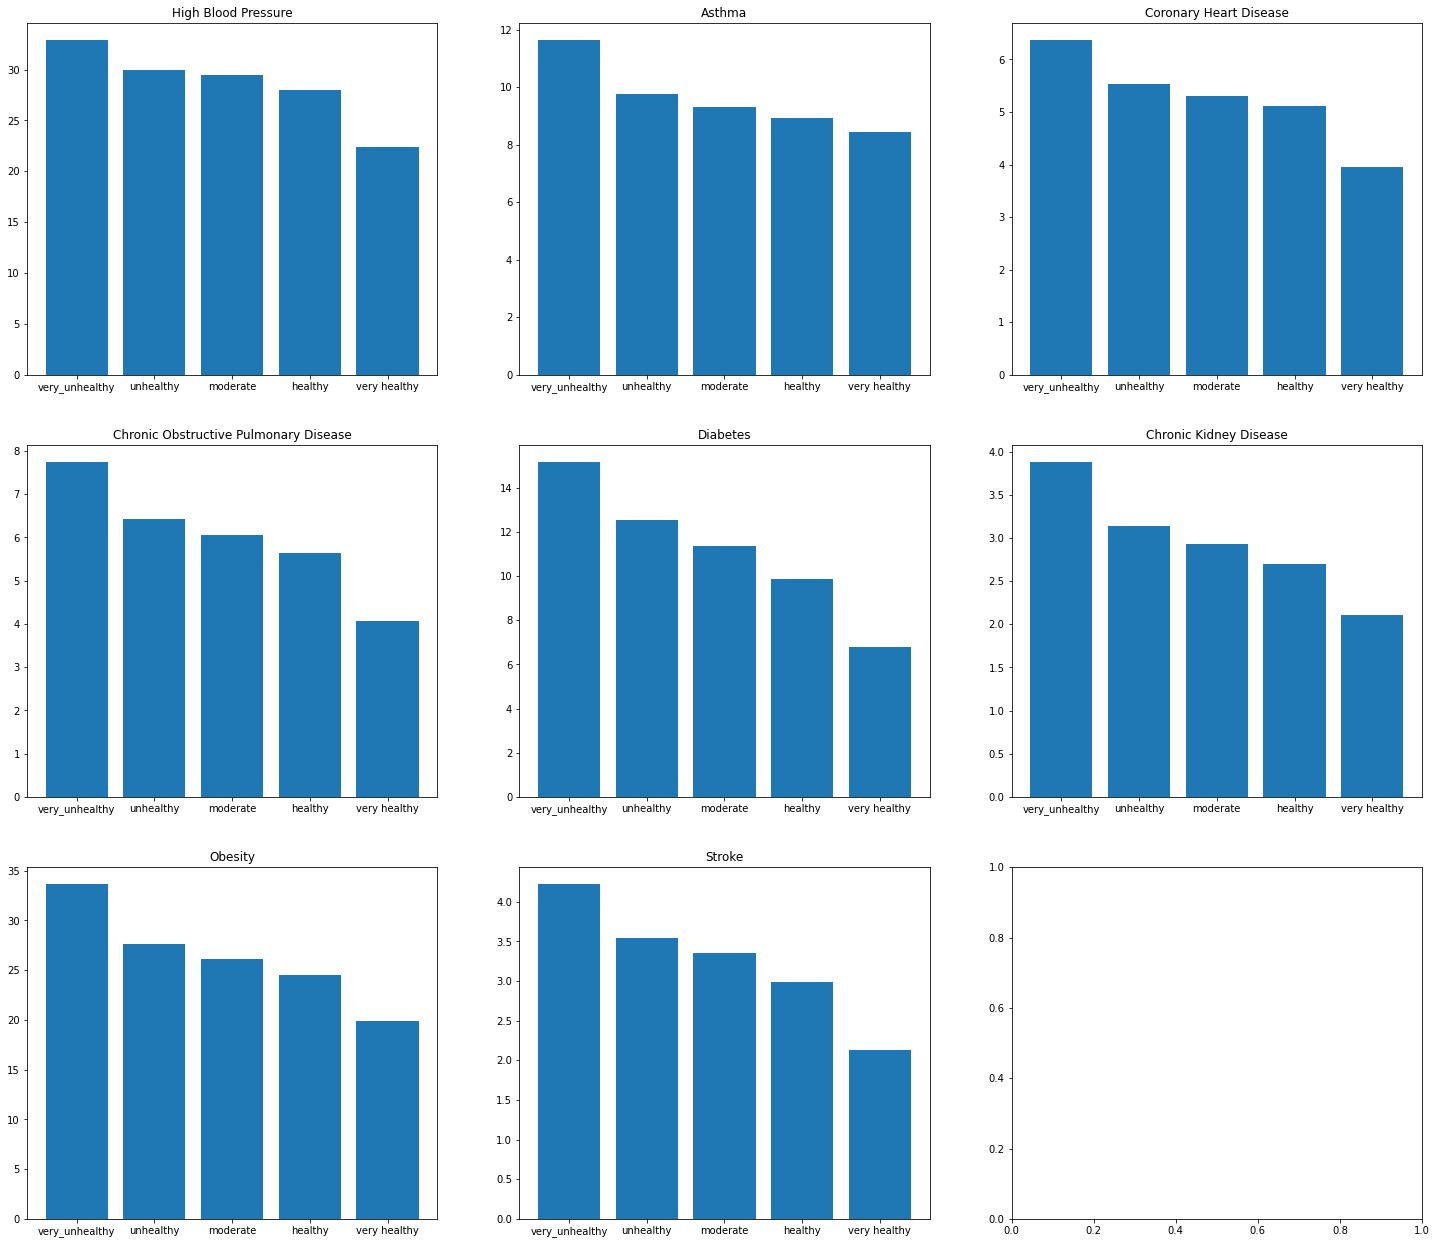

In [149]:
fig, ax = plt.subplots(3,3, figsize=(25,22))

labels = ['High Blood Pressure', 'Asthma', 'Coronary Heart Disease'
         , 'Chronic Obstructive Pulmonary Disease', 'Diabetes', 'Chronic Kidney Disease'
         , 'Obesity', 'Stroke']

for i,j in enumerate(['BPHIGH', 'CASTHMA', 'CHD'
                      , 'COPD', 'DIABETES', 'KIDNEY'
                      , 'OBESITY','STROKE']):
    
    ax[i//3][i%3].bar(x=HCI_Disease.index, height=HCI_Disease[j])
    label = labels[i]
    ax[i//3][i%3].set_title(label)

plt.show()

In [150]:
HCI_Disease

HCI        BE         E        NE        SE  BE_TreeD  \
HCI_Class                                                                    
very_unhealthy -1.362669 -0.371304 -0.979992 -0.581655 -1.479985 -0.321968   
unhealthy      -0.482026 -0.220652 -0.571686 -0.249486 -0.292490 -0.230751   
moderate       -0.044174 -0.168991 -0.245769  0.018410  0.169737 -0.037244   
healthy         0.416494  0.044684  0.224699  0.212298  0.526266  0.234433   
very healthy    1.472212  0.715824  1.571883  0.600340  1.077055  0.355539   

                BE_nodeD  BE_HFood  BE_WalkVSDrive  BE_Transit   BE_Park  \
HCI_Class                                                                  
very_unhealthy -0.167733 -0.303970       -0.278029   -0.180950 -0.006787   
unhealthy      -0.135911 -0.198903       -0.098726    0.002673 -0.251810   
moderate       -0.054157 -0.180534       -0.000837   -0.157515 -0.219891   
healthy         0.017634 -0.078962        0.203685   -0.120717  0.100797   
very healthy    0.339873  0.761677        0.174170    0.456215  0.377314   

                BE_LandUseMix  E_Advance    E_PreS    NE_Tem  NE_Ozone  \
HCI_Class                                                                
very_unhealthy      -0.263531  -1.002094 -0.121304 -0.212422 -0.443237   
unhealthy           -0.056071  -0.554481 -0.291487 -0.311924 -0.123100   
moderate            -0.083445  -0.239023 -0.120543 -0.206568  0.058313   
healthy             -0.044949   0.229302  0.031216  0.079239  0.055899   
very healthy         0.447744   1.565484  0.501469  0.651094  0.451959   

                 NE_PM25  SE_Unemploy  SE_Income   SE_Cash   SE_Food  \
HCI_Class                                                              
very_unhealthy -0.429958    -1.045094  -1.048761 -1.302500 -1.494065   
unhealthy       0.211577    -0.135025  -0.425575 -0.134527 -0.197960   
moderate        0.434868     0.218283  -0.094620  0.268265  0.219565   
healthy         0.353498     0.365365   0.249005  0.475079  0.551482   
very healthy   -0.568576     0.597046   1.319512  0.694533  0.921859   

                SE_Insurance  SE_Poverty  SE_English        MH        PH  \
HCI_Class                                                                  
very_unhealthy     -0.410605   -1.385002   -0.413686 -1.407688 -1.392277   
unhealthy          -0.393151   -0.134048   -0.343765 -0.278496 -0.331252   
moderate           -0.183004    0.281717   -0.146067  0.133505  0.070978   
healthy             0.281299    0.532498    0.162118  0.516482  0.440385   
very healthy        0.705182    0.705829    0.740946  1.036791  1.212439   

                ARTHRITIS     BPHIGH    CANCER    CASTHMA       CHD      COPD  \
HCI_Class                                                                       
very_unhealthy  19.861097  32.932419  4.635910  11.652369  6.375810  7.749377   
unhealthy       18.516500  29.968750  5.098250   9.761250  5.531750  6.417250   
moderate        18.716209  29.435910  5.605985   9.326185  5.305237  6.059102   
healthy         19.062000  27.941500  6.293500   8.924000  5.112750  5.640500   
very healthy    16.556608  22.361845  6.081546   8.442394  3.955362  4.074813   

                DEPRESSION   DIABETES   HIGHCHOL    KIDNEY    OBESITY  \
HCI_Class                                                               
very_unhealthy   17.244888  15.176060  29.505736  3.882045  33.675312   
unhealthy        15.289000  12.550750  29.343500  3.138500  27.637500   
moderate         15.047132  11.378803  29.357107  2.926683  26.173067   
healthy          15.449500   9.882750  29.714000  2.693000  24.484750   
very healthy     16.804738   6.779052  27.645636  2.102993  19.916209   

                  STROKE  TEETHLOST  
HCI_Class                            
very_unhealthy  4.223691  26.030673  
unhealthy       3.540750  19.692500  
moderate        3.347382  16.802743  
healthy         2.991500  13.616250  
very healthy    2.125935   8.462095

# Plot HCI

In [151]:
# geo data
ct2010 = gpd.read_file('./Data/Processed_Data/ct2010_geoid.geojson')
ct2010.head()

boro_code boro_ct201      boro_name cdeligibil  ct2010 ctlabel ntacode  \
0         5    5000900  Staten Island          E  000900       9    SI22   
1         1    1009800      Manhattan          I  009800      98    MN19   
2         1    1010200      Manhattan          I  010200     102    MN17   
3         1    1010400      Manhattan          I  010400     104    MN17   
4         1    1011300      Manhattan          I  011300     113    MN17   

                                     ntaname  puma    shape_area   shape_leng  \
0  West New Brighton-New Brighton-St. George  3903  2.497010e+06  7729.016794   
1                    Turtle Bay-East Midtown  3808  1.906016e+06  5534.200308   
2                      Midtown-Midtown South  3807  1.860993e+06  5687.802439   
3                      Midtown-Midtown South  3807  1.864600e+06  5693.036367   
4                      Midtown-Midtown South  3807  1.890907e+06  5699.860640   

         GeoID                                           geometry  
0  36085000900  POLYGON ((-74.07921 40.64343, -74.07914 40.643...  
1  36061009800  POLYGON ((-73.96433 40.75638, -73.96479 40.755...  
2  36061010200  POLYGON ((-73.97124 40.76094, -73.97170 40.760...  
3  36061010400  POLYGON ((-73.97446 40.76229, -73.97491 40.761...  
4  36061011300  POLYGON ((-73.98412 40.75484, -73.98460 40.754...

In [152]:
HCI_Geo = HCI.merge(ct2010, left_index=True, right_on='GeoID')
HCI_Geo = gpd.GeoDataFrame(HCI_Geo, geometry=HCI_Geo.geometry, crs=4326)
len(HCI_Geo)

2003

In [153]:
HCI_Geo.crs

<Geographic 2D CRS: EPSG:4326>
Name: WGS 84
Axis Info [ellipsoidal]:
- Lat[north]: Geodetic latitude (degree)
- Lon[east]: Geodetic longitude (degree)
Area of Use:
- name: World
- bounds: (-180.0, -90.0, 180.0, 90.0)
Datum: World Geodetic System 1984
- Ellipsoid: WGS 84
- Prime Meridian: Greenwich

In [154]:
HCI_Geo[HCI_Geo.HCI_Class.isnull()]

Empty GeoDataFrame
Columns: [HCI, BE, E, NE, SE, BE_TreeD, BE_nodeD, BE_HFood, BE_WalkVSDrive, BE_Transit, BE_Park, BE_LandUseMix, E_Advance, E_PreS, NE_Tem, NE_Ozone, NE_PM25, SE_Unemploy, SE_Income, SE_Cash, SE_Food, SE_Insurance, SE_Poverty, SE_English, MH, PH, HCI_Class, boro_code, boro_ct201, boro_name, cdeligibil, ct2010, ctlabel, ntacode, ntaname, puma, shape_area, shape_leng, GeoID, geometry]
Index: []

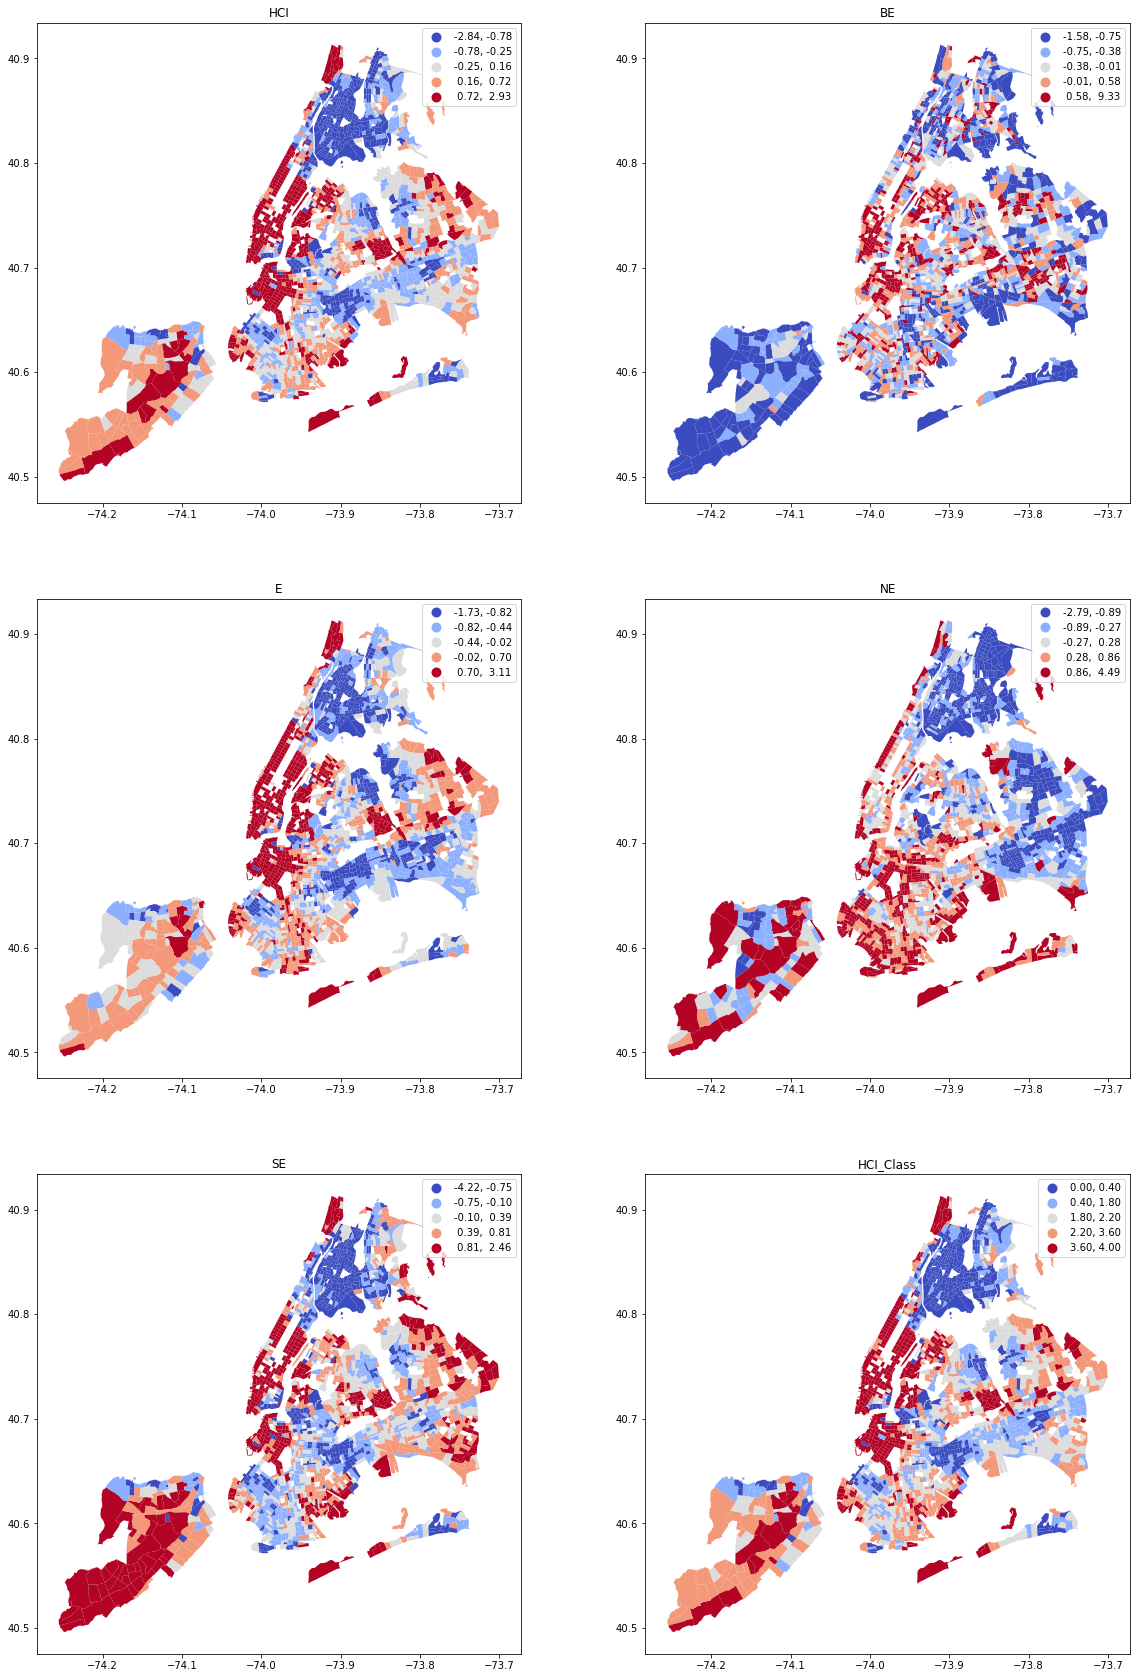

In [155]:
fig, ax = plt.subplots(3,2, figsize=(20,30))

a = ['HCI', 'BE', 'E', 'NE', 'SE', 'HCI_Class']

for i,j in enumerate(a):
    HCI_Geo.plot(column=j, cmap='coolwarm', ax=ax[i//2][i%2],
                              legend=True, scheme='Quantiles', k=5
                              #,figsize=(10,10)
                )
    
    label = j
    ax[i//2][i%2].set_title(label)
    
plt.show()

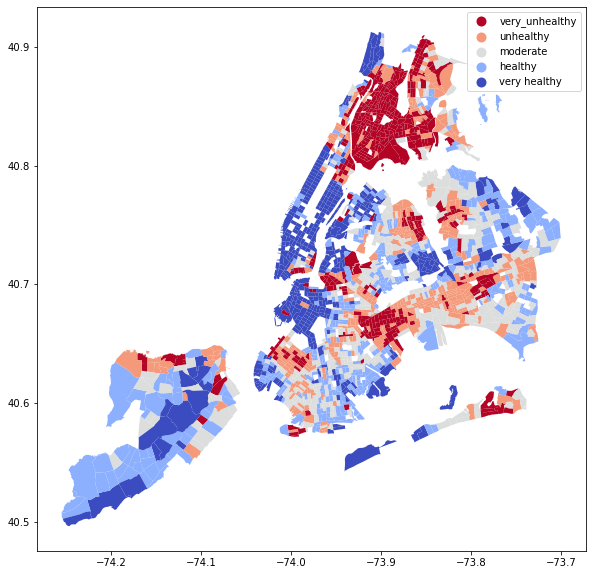

In [156]:
HCI_Geo.plot(column='HCI_Class', cmap='coolwarm_r'
                          ,legend=True
                          ,figsize=(10,10))


plt.show()

<img src="HCI_1.jpg" width="500">
<img src="Covid_19.jpg" width="500">

In [66]:
# Bottom Five
HCI_Geo.sort_values(by='HCI')[['HCI','boro_name','ntaname']].head(5)

HCI boro_name                                           ntaname
507  -2.851743  Brooklyn                                       Brownsville
2134 -2.501385  Brooklyn                                       Brownsville
2124 -2.453969  Brooklyn  DUMBO-Vinegar Hill-Downtown Brooklyn-Boerum Hill
2098 -2.426675  Brooklyn          Carroll Gardens-Columbia Street-Red Hook
1734 -2.396023     Bronx                                     Fordham South

In [67]:
# Top Five
HCI_Geo.sort_values(by='HCI', ascending=False)[['HCI','BE','boro_name','ntaname']].head(5)

HCI        BE  boro_name                                 ntaname
1103  3.188290  0.649519  Manhattan  SoHo-TriBeCa-Civic Center-Little Italy
1050  3.167442  1.701767  Manhattan           Upper East Side-Carnegie Hill
2014  3.141261  5.210896  Manhattan           Upper East Side-Carnegie Hill
1882  3.091803 -0.379774  Manhattan       Battery Park City-Lower Manhattan
1130  2.982766  0.287631  Manhattan       Battery Park City-Lower Manhattan

In [68]:
HCI_Geo.sort_values(by=['HCI','BE'], ascending=True)[['HCI','BE','boro_name','ntaname']].head(5)

HCI        BE boro_name  \
507  -2.851743 -0.067420  Brooklyn   
2134 -2.501385 -0.963854  Brooklyn   
2124 -2.453969 -0.253181  Brooklyn   
2098 -2.426675 -1.303842  Brooklyn   
1734 -2.396023 -0.759464     Bronx   

                                               ntaname  
507                                        Brownsville  
2134                                       Brownsville  
2124  DUMBO-Vinegar Hill-Downtown Brooklyn-Boerum Hill  
2098          Carroll Gardens-Columbia Street-Red Hook  
1734                                     Fordham South

In [69]:
HCI_Geo.sort_values(by=['BE'], ascending=True)[['HCI','BE','boro_name','ntaname']].head(5)

HCI        BE      boro_name  \
1922  0.412326 -1.563910  Staten Island   
1959 -0.561224 -1.530674          Bronx   
1836 -0.511595 -1.481902          Bronx   
2090  0.269687 -1.410581  Staten Island   
1273 -1.122383 -1.408819  Staten Island   

                                       ntaname  
1922                             Arden Heights  
1959                                Co-op City  
1836  Schuylerville-Throgs Neck-Edgewater Park  
2090                             Arden Heights  
1273             Grymes Hill-Clifton-Fox Hills

In [608]:
HCI_Geo.loc[1959]

HCI                                                        -0.45893
BE                                                         -1.54535
E                                                         -0.435833
NE                                                        -1.444404
SE                                                         0.372978
BE_TreeD                                                  -1.501873
BE_nodeD                                                  -0.724669
BE_HFood                                                  -0.789925
BE_WalkVSDrive                                            -1.705593
BE_Transit                                                -0.794684
BE_Park                                                   -0.527697
BE_LandUseMix                                             -0.994081
E_Advance                                                 -0.500959
E_PreS                                                      0.35156
NE_Tem                                          

In [602]:
HCI_Geo.describe()

HCI            BE             E            NE            SE  \
count  2.003000e+03  2.003000e+03  2.003000e+03  2.003000e+03  2.003000e+03   
mean   6.097081e-17  5.875369e-18  2.704887e-17 -8.648155e-17 -7.737750e-16   
std    1.000250e+00  1.000250e+00  1.000250e+00  1.000250e+00  1.000250e+00   
min   -2.841195e+00 -1.575208e+00 -1.729949e+00 -2.788903e+00 -4.216567e+00   
25%   -6.069686e-01 -6.425062e-01 -7.123303e-01 -7.253256e-01 -5.693898e-01   
50%   -3.716347e-02 -2.251530e-01 -2.419444e-01 -2.119227e-02  1.545536e-01   
75%    5.454369e-01  3.905217e-01  4.588610e-01  6.921717e-01  7.027924e-01   
max    2.933547e+00  9.329372e+00  3.109886e+00  4.487221e+00  2.463583e+00   

           BE_TreeD      BE_nodeD      BE_HFood  BE_WalkVSDrive    BE_Transit  \
count  2.003000e+03  2.003000e+03  2.003000e+03    2.003000e+03  2.003000e+03   
mean   8.580256e-17  1.830233e-16  1.001584e-16    5.875369e-17 -7.687865e-17   
std    1.000250e+00  1.000250e+00  1.000250e+00    1.000250e+00  1.000250e+00   
min   -1.576767e+00 -9.247896e-01 -8.427909e-01   -1.705593e+00 -8.399752e-01   
25%   -6.712587e-01 -6.056768e-01 -6.049943e-01   -7.271296e-01 -5.316181e-01   
50%   -2.240173e-01 -3.092471e-01 -3.002026e-01   -2.417505e-01 -2.624141e-01   
75%    4.123965e-01  2.228342e-01  2.565845e-01    4.773823e-01  1.744087e-01   
max    8.910007e+00  1.060682e+01  1.209812e+01    5.284428e+00  1.637621e+01   

            BE_Park  BE_LandUseMix     E_Advance        E_PreS        NE_Tem  \
count  2.003000e+03   2.003000e+03  2.003000e+03  2.003000e+03  2.003000e+03   
mean  -9.699902e-20  -9.744244e-17  1.050915e-16  3.436537e-18  2.993112e-18   
std    1.000250e+00   1.000250e+00  1.000250e+00  1.000250e+00  1.000250e+00   
min   -7.994300e-01  -2.607823e+00 -1.617843e+00 -2.185710e+00 -2.533679e+00   
25%   -6.318323e-01  -6.912042e-01 -7.233476e-01 -6.966696e-01 -7.168267e-01   
50%   -3.794621e-01  -4.852676e-02 -2.390351e-01  7.388305e-02 -1.046276e-01   
75%    2.189587e-01   6.529565e-01  4.651947e-01  8.392292e-01  6.119116e-01   
max    7.312495e+00   3.221531e+00  3.057255e+00  1.285247e+00  4.967190e+00   

           NE_Ozone       NE_PM25   SE_Unemploy     SE_Income       SE_Cash  \
count  2.003000e+03  2.003000e+03  2.003000e+03  2.003000e+03  2.003000e+03   
mean  -3.583310e-15 -2.897665e-15  2.239292e-16  3.225910e-17  9.522532e-16   
std    1.000250e+00  1.000250e+00  1.000250e+00  1.000250e+00  1.000250e+00   
min   -2.897435e+00 -1.455635e+00 -7.627718e+00 -1.763549e+00 -7.527743e+00   
25%   -8.367584e-01 -8.253654e-01 -3.973880e-01 -6.693617e-01 -4.342228e-01   
50%    2.937986e-01 -1.590663e-01  2.343885e-01 -1.329404e-01  3.003813e-01   
75%    9.171630e-01  6.647826e-01  6.789719e-01  4.601579e-01  7.135960e-01   
max    1.146729e+00  3.345059e+00  1.521340e+00  5.237595e+00  1.034985e+00   

            SE_Food  SE_Insurance    SE_Poverty    SE_English            MH  \
count  2.003000e+03  2.003000e+03  2.003000e+03  2.003000e+03  2.003000e+03   
mean  -2.979810e-16  2.169341e-15 -2.330194e-16  3.565407e-16 -1.543559e-15   
std    1.000250e+00  1.000250e+00  1.000250e+00  1.000250e+00  1.000250e+00   
min   -3.775344e+00 -6.891663e+00 -5.151382e+00 -4.555211e+00 -3.918971e+00   
25%   -5.316497e-01 -4.640354e-01 -5.319710e-01 -5.598180e-01 -5.573206e-01   
50%    2.889661e-01  1.767249e-01  2.602008e-01  1.897731e-01  1.430233e-01   
75%    7.865048e-01  7.173665e-01  7.469570e-01  8.156453e-01  6.682812e-01   
max    1.264659e+00  1.518317e+00  1.472319e+00  1.317799e+00  2.139003e+00   

                 PH    shape_area    shape_leng         GeoID  
count  2.003000e+03  2.003000e+03   2003.000000  2.003000e+03  
mean   2.153046e-15  3.366799e+06   8111.628971  3.605455e+10  
std    1.000250e+00  5.153910e+06   5380.339703  2.607857e+07  
min   -3.818510e+00  4.478077e+05   2816.869528  3.600500e+10  
25%   -5.187955e-01  1.675675e+06   5605.867521  3.604702e+10  
50%    9.442586e-02  1.970412e+06   6484.3921

In [609]:
ct2010

boro_code boro_ct201      boro_name cdeligibil  ct2010 ctlabel ntacode  \
0            5    5000900  Staten Island          E  000900       9    SI22   
1            1    1009800      Manhattan          I  009800      98    MN19   
2            1    1010200      Manhattan          I  010200     102    MN17   
3            1    1010400      Manhattan          I  010400     104    MN17   
4            1    1011300      Manhattan          I  011300     113    MN17   
...        ...        ...            ...        ...     ...     ...     ...   
2160         2    2011502          Bronx          E  011502  115.02    BX27   
2161         5    5023900  Staten Island          E  023900     239    SI12   
2162         5    5022300  Staten Island          I  022300     223    SI12   
2163         5    5020700  Staten Island          E  020700     207    SI28   
2164         5    5021300  Staten Island          E  021300     213    SI28   

                                                ntaname  puma    shape_area  \
0             West New Brighton-New Brighton-St. George  3903  2.497010e+06   
1                               Turtle Bay-East Midtown  3808  1.906016e+06   
2                                 Midtown-Midtown South  3807  1.860993e+06   
3                                 Midtown-Midtown South  3807  1.864600e+06   
4                                 Midtown-Midtown South  3807  1.890907e+06   
...                                                 ...   ...           ...   
2160                                        Hunts Point  3710  3.725364e+06   
2161  Mariner's Harbor-Arlington-Port Ivory-Granitev...  3903  5.672822e+06   
2162  Mariner's Harbor-Arlington-Port Ivory-Granitev...  3903  7.075135e+06   
2163                                      Port Richmond  3903  9.980453e+06   
2164                                      Port Richmond  3903  8.432870e+06   

        shape_leng        GeoID  \
0      7729.016794  36085000900   
1      5534.200308  36061009800   
2      5687.802439  36061010200   
3      5693.036367  36061010400   
4      5699.860640  36061011300   
...            ...          ...   
2160   7796.416044  36005011502   
2161  11002.065738  36085023900   
2162  22768.668111  36085022300   
2163  21807.677016  36085020700   
2164  14578.849421  36085021300   

                                               geometry  
0     POLYGON ((-74.07921 40.64343, -74.07914 40.643...  
1     POLYGON ((-73.96433 40.75638, -73.96479 40.755...  
2     POLYGON ((-73.97124 40.76094, -73.97170 40.760...  
3     POLYGON ((-73.97446 40.76229, -73.97491 40.761...  
4     POLYGON ((-73.98412 40.75484, -73.98460 40.754...  
...                                                 ...  
2160  POLYGON ((-73.88098 40.81824, -73.88127 40.818...  
2161  POLYGON ((-74.14691 40.63116, -74.14737 40.629...  
2162  MULTIPOLYGON (((-74.14313 40.63968, -74.14360 ...  
2163  MULTIPOLYGON (((-74.12613 40.64126, -74.12600 ...  
2164  POLYGON ((-74.13047 40.63168, -74.13060 40.631...  

[2165 rows x 13 columns]